In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import torch
from pytorch_lightning.callbacks import Callback, EarlyStopping
import random
import numpy as np
import pandas as pd
from tqdm import tqdm_notebook as tqdm
import datetime as dt
import yfinance as yf

import matplotlib.pyplot as plt

from darts import TimeSeries, concatenate
from darts.dataprocessing.transformers import Scaler, BoxCox
from darts.models import TFTModel, NaiveSeasonal, NaiveDrift
from darts.metrics import mape, smape, mae, rmse
from darts.utils.statistics import extract_trend_and_seasonality, check_seasonality, plot_acf, plot_pacf
from darts.utils.statistics import plot_pacf, plot_residuals_analysis, remove_from_series, remove_seasonality, remove_trend,stationarity_test_kpss
from darts.datasets import AirPassengersDataset, IceCreamHeaterDataset,MonthlyMilkDataset, ElectricityDataset
from darts.utils.timeseries_generation import datetime_attribute_timeseries
from darts.utils.likelihood_models import QuantileRegression

import optuna
from optuna.integration import PyTorchLightningPruningCallback
from optuna.visualization import (
    plot_optimization_history,
    plot_contour,
    plot_param_importances,
)

import warnings

warnings.filterwarnings("ignore")
import logging

logging.disable(logging.CRITICAL)


The StatsForecast module could not be imported. To enable support for the StatsForecastAutoARIMA, StatsForecastAutoETS and Croston models, please consider installing it.


In [2]:
# before starting, we define some constants
num_samples = 200

figsize = (9, 6)
lowest_q, low_q, high_q, highest_q = 0.01, 0.1, 0.9, 0.99
label_q_outer = f"{int(lowest_q * 100)}-{int(highest_q * 100)}th percentiles"
label_q_inner = f"{int(low_q * 100)}-{int(high_q * 100)}th percentiles"

## 1) Import Daily Data, Resample to collect last observation of each month only, converting to Darts object

In [4]:
## For Step 1.1: downloading of stock prices. only 1 stock
def extract_all(stocks: list, 
                start: dt.datetime, 
                end: dt.datetime):
            
    def extract_single_ticker(ticker):
           
        return(yf
               .download(ticker, 
                               start,
                               end, ignore_tz=True, multi_level_index=True)
               )
    interim_df = map(extract_single_ticker, stocks) # applies the extract_single_ticker function to the stocks (list of tickers)
    
    return(pd
           .concat(interim_df,
                  keys = stocks,
                  names = ["ticker", "date"]
                 )
          )
    

    
    ## For Step 1.2: converting multiindex DF long format to singleindex wide format
def multiindex_to_wide(stock_MI: pd.DataFrame):
    
    stock_wide =\
    (
        stock_MI['Adj Close'].reset_index()\
            .pivot(index = 'date',
                columns = 'ticker',
                values = 'Adj Close')            
    )
    return stock_wide
    
tickers = ['^GSPC']
start = dt.datetime(2013, 1, 1)
end = dt.datetime(2024, 10, 6)


gspc =\
(
    yf
    .download(
        ["^GSPC"],
        start = start,
        end = end
    )
)

gspc= gspc.droplevel(1, axis = 1).loc[:, ["Adj Close"]].rename({"Adj Close": "^GSPC"}, axis =1)
gspc.index = gspc.index.tz_localize(None)

# gspc = multiindex_to_wide(gspc)
#gspc.index = gspc.index.rename('Date')

[*********************100%***********************]  1 of 1 completed


In [5]:
gspc.index

DatetimeIndex(['2013-01-02', '2013-01-03', '2013-01-04', '2013-01-07',
               '2013-01-08', '2013-01-09', '2013-01-10', '2013-01-11',
               '2013-01-14', '2013-01-15',
               ...
               '2024-09-23', '2024-09-24', '2024-09-25', '2024-09-26',
               '2024-09-27', '2024-09-30', '2024-10-01', '2024-10-02',
               '2024-10-03', '2024-10-04'],
              dtype='datetime64[ns]', name='Date', length=2960, freq=None)

In [6]:
# Import df, set datetimeindex so later can use resample function
df = pd.read_csv(r"C:\Users\limfy\OneDrive\Documents\SMU MQF\Course\quant analysis in financial markets\Project\models\lstm v2\combined_data.csv")\
    .drop(labels = ['Sentiment Text'], axis = 1)
df = df.drop([f"Sentiment Lag_{i}" for i in range(1,6)], axis = 1)   
df = df.set_index('Date', drop = False)
df.index = pd.to_datetime(df.index)
df.index = df.index.tz_localize(None)

# Join SPY 
df = pd.merge(left = df, right = gspc, how = 'left', left_index = True, right_index = True)
df.loc['2014-01-01', '^GSPC'] = 1848.36 # fill with 31st Dec 'GSPC' adjusted close
df['^GSPC'] = df['^GSPC'].ffill(axis = 0)  # ffill for SPY from previous row (day)

display(df)

# Resample to month end data
df = df.resample(rule = 'BMS').first() # if 'BME' need below code
# df = df.drop(labels = df.index[-1], axis = 0) # Drop last entry, because it is not MonthEnd
print("df:")
display(df)
print('\n')


### Convert to darts Time Series

series = TimeSeries.from_dataframe(df = df, 
                                   time_col = 'Date',
                                   freq='BMS') # or 'BME
print("Darts Time Series Object:")
display(series)


,Date,IXN,VNQ,XLE,XLF,XLY,Sentiment Value,GDPC1,CPIAUCSL,UNRATE,PAYEMS,RRSFS,GFDEBTN,VIXCLS,DFF,^GSPC
Date,,,,,,,,,,,,,,,,
2014-01-01,2014-01-01,12.641662,42.107735,58.413666,14.477487,58.956947,-1.0,17974.698333,234.719,6.7,137367.0,180128.0,1.745286e+07,13.72,0.07,1848.360000
2014-01-02,2014-01-02,12.486846,42.114258,57.582096,14.398009,58.683434,-1.0,17974.698333,234.719,6.7,137367.0,180128.0,1.745286e+07,13.72,0.07,1831.979980
2014-01-03,2014-01-03,12.436762,42.349052,57.370922,14.497356,58.524654,-1.0,17974.698333,234.719,6.7,137367.0,180128.0,1.745286e+07,13.72,0.07,1831.369995
2014-01-06,2014-01-06,12.406402,42.564293,57.450108,14.510599,58.162983,-1.0,17974.698333,234.719,6.7,137367.0,180128.0,1.745286e+07,13.72,0.07,1826.770020
2014-01-07,2014-01-07,12.489882,42.753437,57.885685,14.517219,58.515846,-1.0,17974.698333,234.719,6.7,137367.0,180128.0,1.745286e+07,13.72,0.07,1837.880005
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-10-07,2024-10-07,81.199997,94.269997,93.510002,45.090000,195.089996,1.0,22924.863000,314.121,4.2,158779.0,226274.0,3.483163e+07,16.15,4.83,5751.069824
2024-10-08,2024-10-08,82.669998,94.459999,91.070000,45.349998,196.990005,1.0,22924.863000,314.121,4.2,158779.0,226274.0,3.483163e+07,16.15,4.83,5751.069824
2024-10-09,2024-10-09,83.650002,94.559998,91.620003,45.770000,198.399994,1.0,22924.863000,314.121,4.2,158779.0,226274.0,3.483163e+07,16.15,4.83,5751.069824


df:


,Date,IXN,VNQ,XLE,XLF,XLY,Sentiment Value,GDPC1,CPIAUCSL,UNRATE,PAYEMS,RRSFS,GFDEBTN,VIXCLS,DFF,^GSPC
Date,,,,,,,,,,,,,,,,
2014-01-01,2014-01-01,12.641662,42.107735,58.413666,14.477487,58.956947,-1.0,17974.698333,234.719,6.7,137367.0,180128.0,1.745286e+07,13.72,0.07,1848.360000
2014-02-03,2014-02-03,11.948031,43.209999,54.044678,13.596649,53.963722,-1.0,17953.974000,235.288,6.6,137551.0,178086.0,1.760123e+07,18.41,0.07,1741.890015
2014-03-03,2014-03-03,12.626482,46.158058,57.476517,14.258929,58.409981,-1.0,18031.286333,235.547,6.7,137710.0,180343.0,1.761169e+07,14.00,0.06,1845.729980
2014-04-01,2014-04-01,12.975574,46.571270,59.417236,14.876801,58.071640,-1.0,18108.598667,236.028,6.7,137987.0,181814.0,1.762215e+07,13.88,0.06,1885.520020
2014-05-01,2014-05-01,12.802545,48.087780,62.030270,14.624202,56.717640,1.0,18185.911000,236.468,6.2,138298.0,183336.0,1.763261e+07,13.41,0.09,1883.680054
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-06-03,2024-06-03,76.904732,81.345200,89.299492,41.067860,175.151016,1.0,22924.863000,313.225,4.0,158430.0,224857.0,3.483163e+07,12.92,5.33,5283.399902
2024-07-01,2024-07-01,83.620003,82.277092,90.453011,41.051117,182.643143,1.0,22924.863000,313.049,4.1,158548.0,224358.0,3.483163e+07,12.44,5.33,5475.089844
2024-08-01,2024-08-01,77.680000,90.557358,89.996780,42.964180,182.513412,1.0,22924.863000,313.534,4.3,158637.0,226581.0,3.483163e+07,16.36,5.33,5446.680176




Darts Time Series Object:


<TimeSeries (DataArray) (Date: 130, component: 15, sample: 1)>
array([[[1.26416616e+01],
        [4.21077347e+01],
        [5.84136658e+01],
        ...,
        [1.37200000e+01],
        [7.00000000e-02],
        [1.84836000e+03]],

       [[1.19480314e+01],
        [4.32099991e+01],
        [5.40446777e+01],
        ...,
        [1.84100000e+01],
        [7.00000000e-02],
        [1.74189001e+03]],

       [[1.26264820e+01],
        [4.61580582e+01],
        [5.74765167e+01],
        ...,
...
        ...,
        [1.63600000e+01],
        [5.33000000e+00],
        [5.44668018e+03]],

       [[8.13499985e+01],
        [9.43355331e+01],
        [9.05323563e+01],
        ...,
        [1.50000000e+01],
        [5.33000000e+00],
        [5.64839990e+03]],

       [[8.08099976e+01],
        [9.67900009e+01],
        [8.98000031e+01],
        ...,
        [1.61500000e+01],
        [4.83000000e+00],
        [5.70875000e+03]]])
Coordinates:
  * Date       (Date) datetime64[ns] 2014-01-01 2014-02-03 ... 2024-10-01
  * component  (component) object 'IXN' 'VNQ' 'XLE' ... 'VIXCLS' 'DFF' '^GSPC'
Dimensions without coordinates: sample
Attributes:
    static_covariates:  None
    hierarchy:          None

## Part 2) Some EDA

2.1 Plot variables and logged variables (Timeplot)

<Axes: xlabel='Date'>

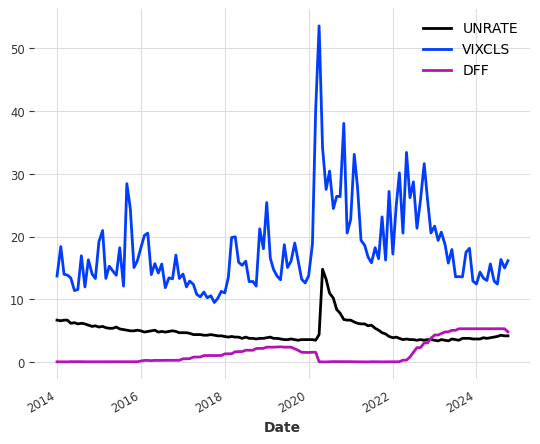

In [7]:
series[['UNRATE','VIXCLS','DFF']].plot()

<Axes: xlabel='Date'>

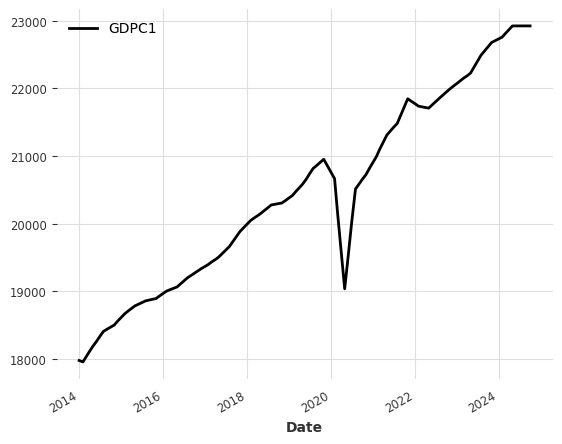

In [8]:
series['GDPC1'].plot()

<Axes: xlabel='Date'>

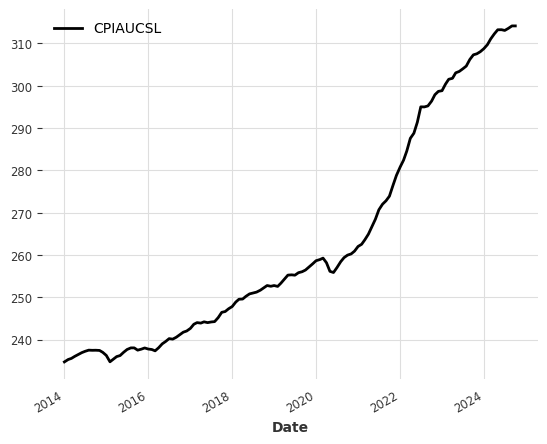

In [9]:
series['CPIAUCSL'].plot()

<Axes: xlabel='Date'>

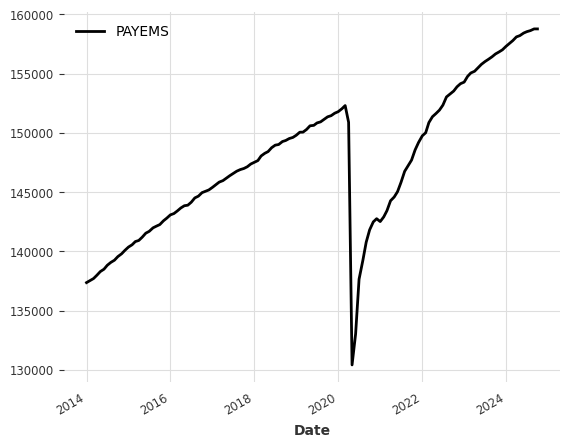

In [10]:
series['PAYEMS'].plot()

<Axes: xlabel='Date'>

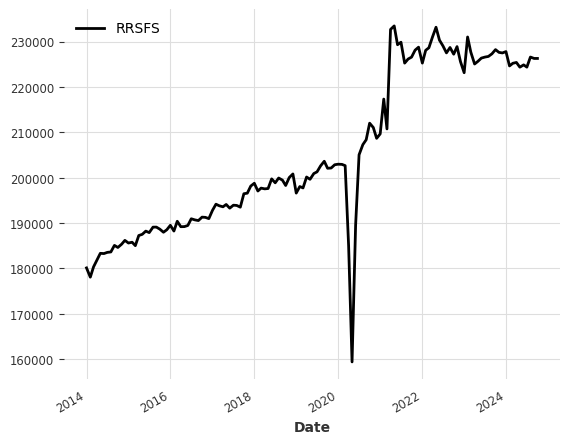

In [11]:
series['RRSFS'].plot()

<Axes: xlabel='Date'>

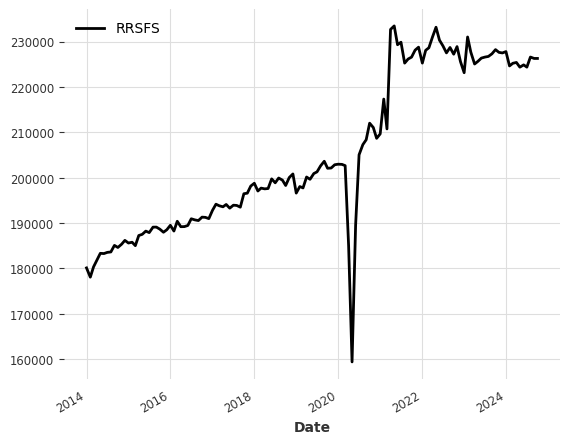

In [12]:
series['RRSFS'].plot()

<Axes: xlabel='Date'>

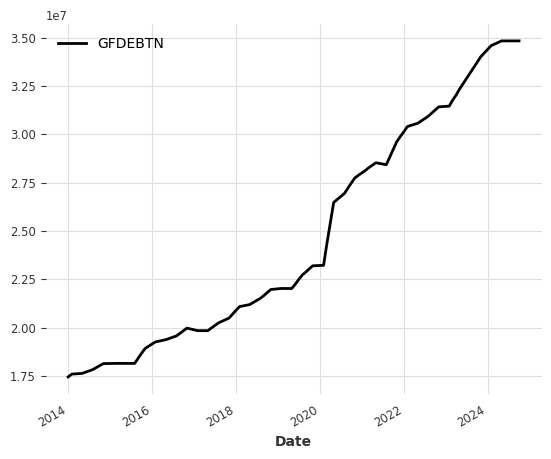

In [13]:
series['GFDEBTN'].plot()

<Axes: xlabel='Date'>

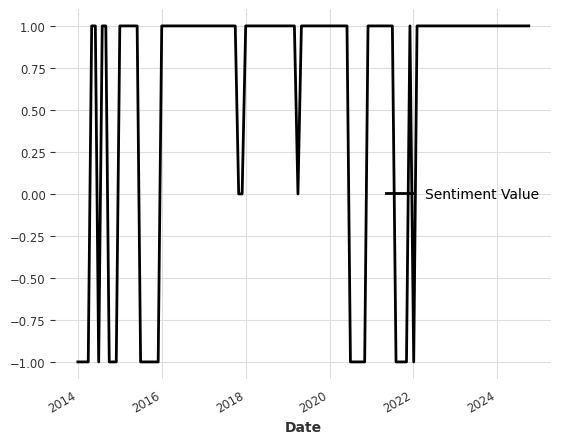

In [14]:
series['Sentiment Value'].plot()

Plot variables, logged

<Axes: xlabel='Date'>

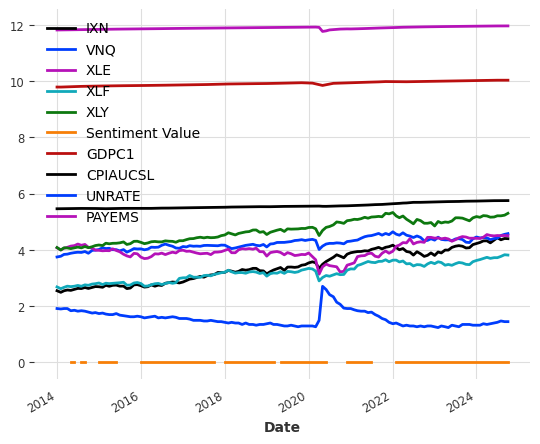

In [15]:
#Plot mapped vaiables:
series.map(np.log).plot()

<Axes: xlabel='Date'>

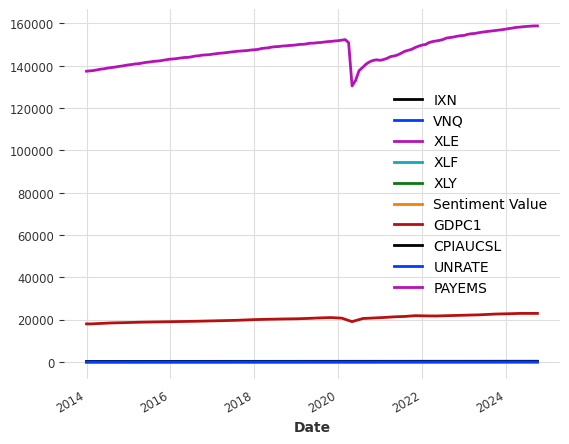

In [16]:
# Adding some datetime attribute as an extra dimension (yielding a multivariate series):
(series).add_datetime_attribute("month").plot()

<Axes: xlabel='Date'>

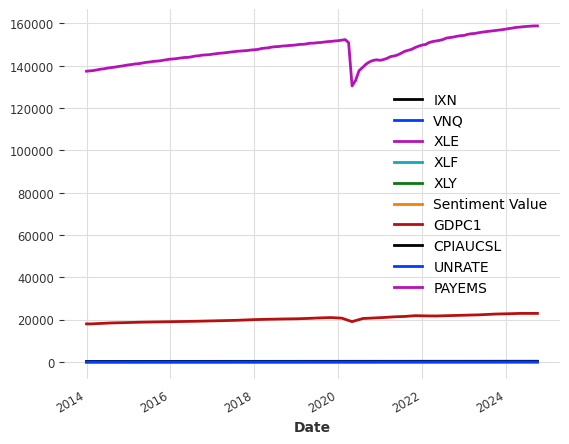

In [17]:
# Adding holiday component
(series).add_holidays("US").plot()

2.2 EDA on differenced variables

<Axes: xlabel='Date'>

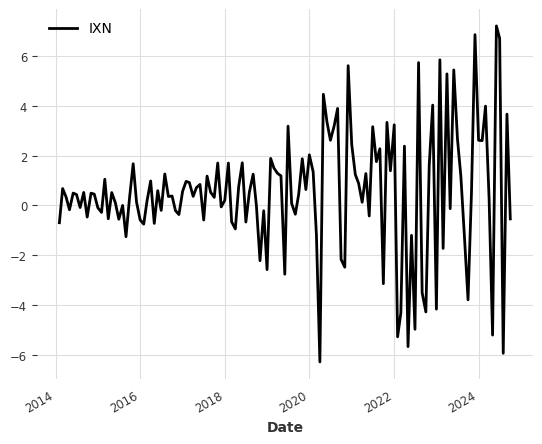

In [18]:
#differencing
series['IXN'].diff().plot()

<Axes: xlabel='Date'>

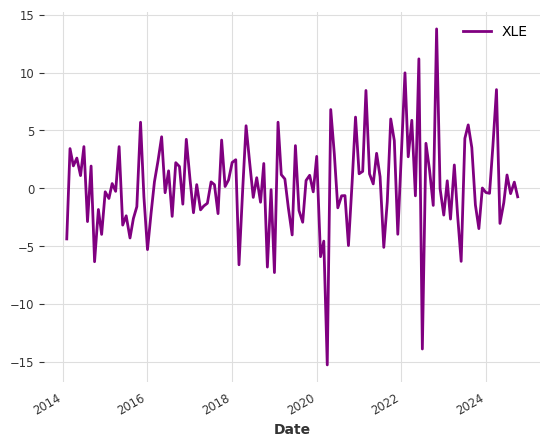

In [19]:
series['XLE'].diff().plot(color = 'purple')

<Axes: xlabel='Date'>

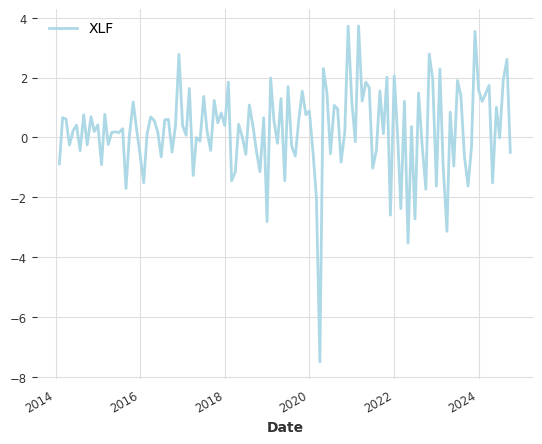

In [20]:
series['XLF'].diff().plot(color = 'lightblue')

<Axes: xlabel='Date'>

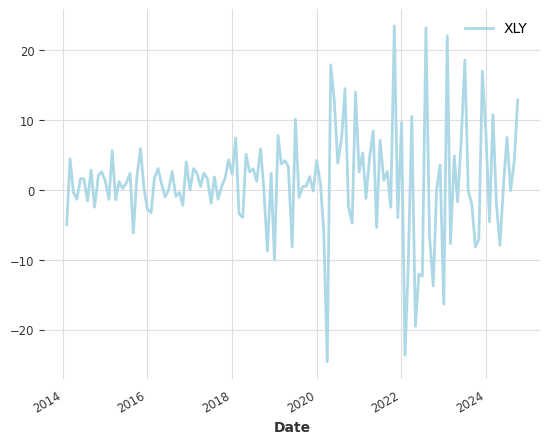

In [21]:
series['XLY'].diff().plot(color = 'lightblue')

<Axes: xlabel='Date'>

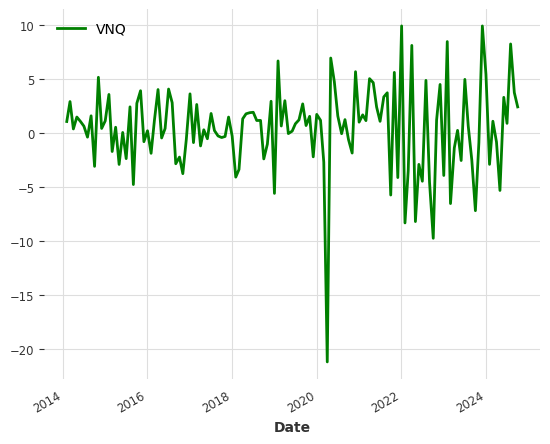

In [22]:
series['VNQ'].diff().plot(color = 'g')

<Axes: xlabel='Date'>

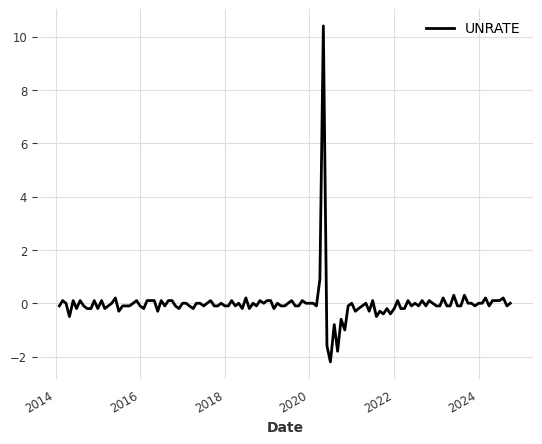

In [23]:
series[['UNRATE']].diff().plot()


<Axes: xlabel='Date'>

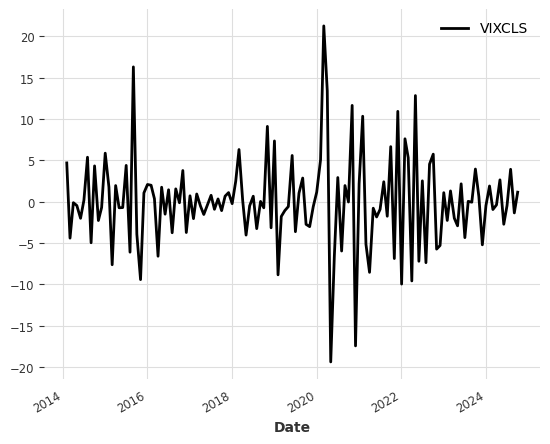

In [24]:
series[['VIXCLS']].diff().plot()


<Axes: xlabel='Date'>

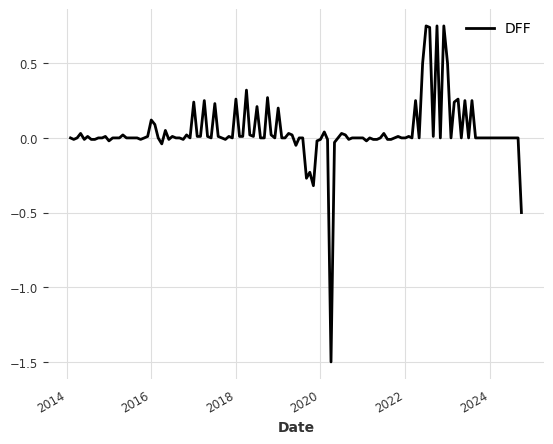

In [25]:
series[['DFF']].diff().plot()

<Axes: xlabel='Date'>

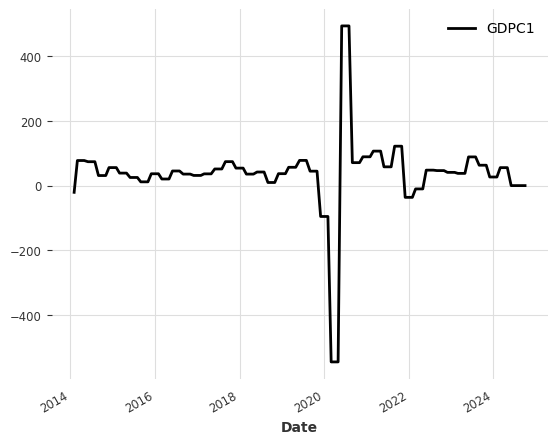

In [26]:
series['GDPC1'].diff().plot()

<Axes: xlabel='Date'>

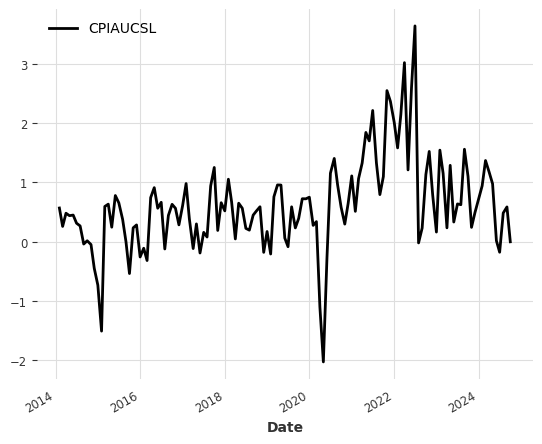

In [27]:
series['CPIAUCSL'].diff().plot()

<Axes: xlabel='Date'>

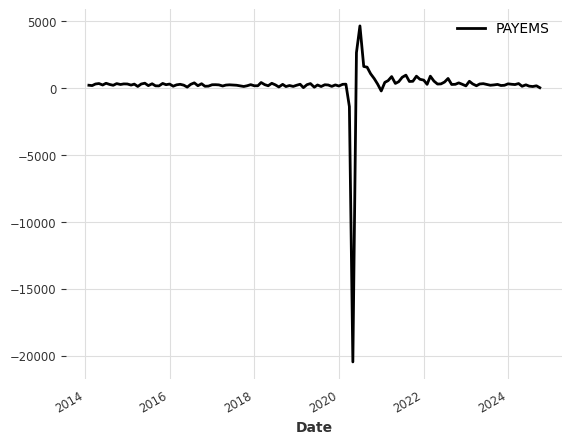

In [28]:
series['PAYEMS'].diff().plot()

<Axes: xlabel='Date'>

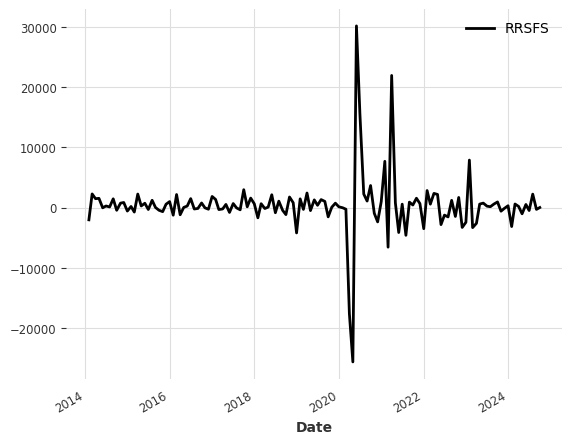

In [29]:
series['RRSFS'].diff().plot()

<Axes: xlabel='Date'>

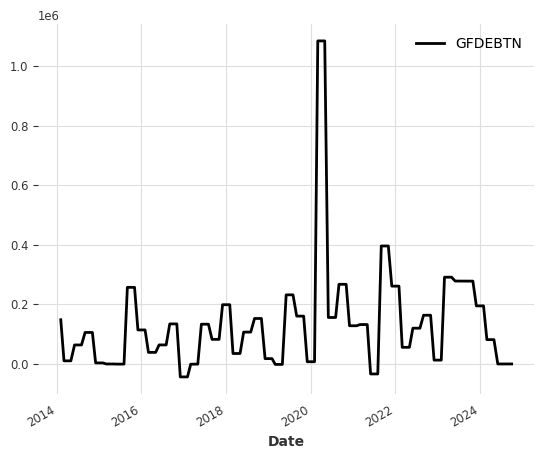

In [30]:
series['GFDEBTN'].diff().plot()

## 3) Data Preprocessing (Scaling) ; Perform Train, Val Split on Series (Y)  and Covariates (X)

In [31]:
y_column_names = series.columns[0:5].to_list()
x_column_names = series.columns[6:-1].to_list()
display(y_column_names)
display(x_column_names)

date_to_split_before = pd.Timestamp(year = 2024, month = 1, day = 1)

### Splitting series into covariates (independent vars_ & series (dependent vars)
covariates = series[x_column_names] # covariates_train + covariates_val
series = series[y_column_names] #ytrain + yval


### Train Val Split on Y
ytrain, yval = series.split_before(date_to_split_before)

### Normalize "series" Y by MinMaxScaler
transformer = Scaler()  ## Scaling on Y (Forecasted Variable) only
ytrain_transformed = transformer.fit_transform(ytrain)
yval_transformed = transformer.transform(yval)
series_transformed = transformer.transform(series)


### Split X
scaler_covs = Scaler()
covariates_train, covariates_val = covariates.split_before(date_to_split_before)
scaler_covs.fit(covariates_train)
covariates_transformed = scaler_covs.transform(covariates)
covariates_train_transformed = scaler_covs.transform(covariates_train)
covariates_val_transformed = scaler_covs.transform(covariates_val)


['IXN', 'VNQ', 'XLE', 'XLF', 'XLY']

['GDPC1', 'CPIAUCSL', 'UNRATE', 'PAYEMS', 'RRSFS', 'GFDEBTN', 'VIXCLS', 'DFF']

## 4) Build a Naive Seasonal Model as a baseline model

<Axes: xlabel='Date'>

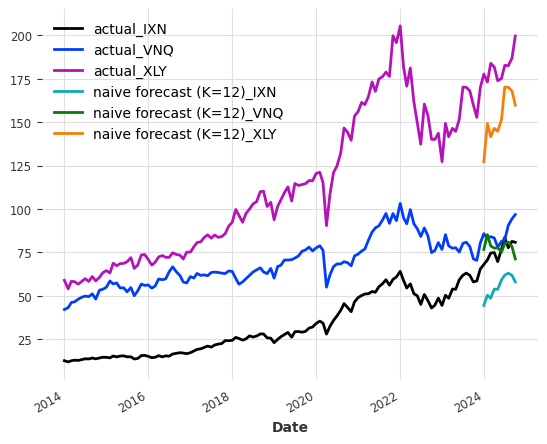

In [32]:
n_timesteps_to_forecast = len(yval) # 10 # i.e. forecast horizon
naive_seasonal_model = NaiveSeasonal(K=12) # Repeat value from 12 steps ago
naive_seasonal_model.fit(ytrain)
naive_seasonal_forecast = naive_seasonal_model.predict(n_timesteps_to_forecast) # Predict 10 timestamps ahead

series[['IXN', 'VNQ', 'XLY']].plot(label="actual")
naive_seasonal_forecast[['IXN', 'VNQ','XLY']].plot(label="naive forecast (K=12)")


'MAPE for Seasonal Naive: 15.77855207974836'

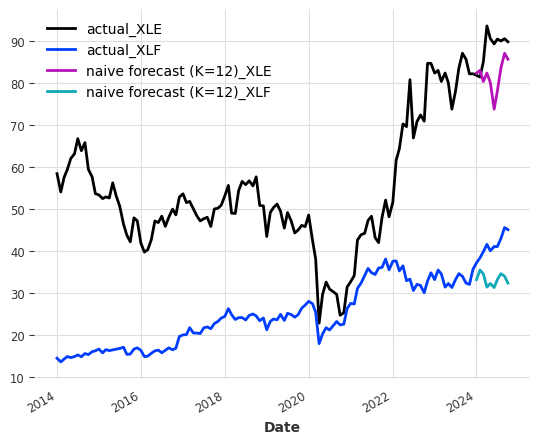

In [33]:
series[['XLE', 'XLF']].plot(label="actual")
naive_seasonal_forecast[['XLE', 'XLF']].plot(label="naive forecast (K=12)")
display(f"MAPE for Seasonal Naive: {mape(yval,naive_seasonal_forecast)}")

<Axes: xlabel='Date'>

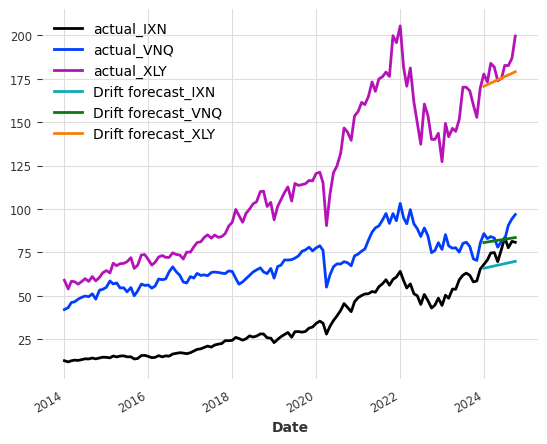

In [34]:
drift_model = NaiveDrift()
drift_model.fit(ytrain)
drift_forecast = drift_model.predict(n_timesteps_to_forecast)

series[['IXN', 'VNQ', 'XLY']].plot(label="actual")
drift_forecast[['IXN', 'VNQ','XLY']].plot(label="Drift forecast")


'MAPE for Seasonal Drift: 7.280685998547364'

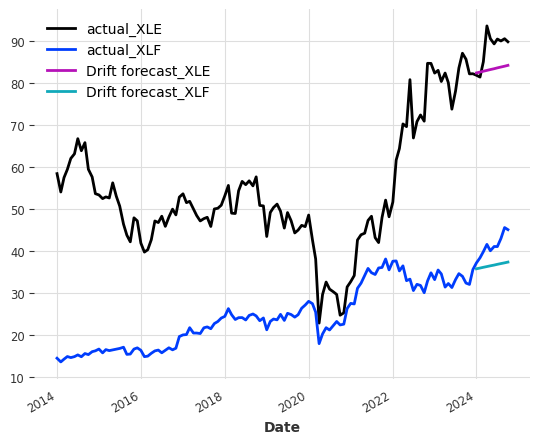

In [35]:
series[['XLE', 'XLF']].plot(label="actual")
drift_forecast[['XLE', 'XLF']].plot(label="Drift forecast")
display(f"MAPE for Seasonal Drift: {mape(yval,drift_forecast)}")

## 5) Fit Temporal Fusion Transformer Model

Darts’ TFTModel incorporates the following main components from the original Temporal Fusion Transformer (TFT) architecture as outlined in this [paper](https://arxiv.org/pdf/1912.09363):

gating mechanisms: skip over unused components of the model architecture

variable selection networks: select relevant input variables at each time step.

temporal processing of past and future input with LSTMs (long short-term memory)

multi-head attention: captures long-term temporal dependencies

prediction intervals: per default, produces quantile forecasts instead of deterministic values

In [36]:
""" We write a function to build and fit a TFT Model, which we will re-use later.
"""


def build_fit_tcn_model(
    input_chunk_length,
    output_chunk_length, #n_timesteps_to_forecast
    hidden_size,
    lstm_layers,
    batch_size,
    n_epochs,
    dropout,
    include_month,
    likelihood=None,
    callbacks=None,
):

    # reproducibility
    torch.manual_seed(42)

    # # some fixed parameters that will be the same for all models
    # BATCH_SIZE = 1024
    # MAX_N_EPOCHS = 30
    # NR_EPOCHS_VAL_PERIOD = 1
    # MAX_SAMPLES_PER_TS = 1000

    # throughout training we'll monitor the validation loss for early stopping
    early_stopper = EarlyStopping("val_loss", min_delta=0.001, patience=3, verbose=True)
    if callbacks is None:
        callbacks = [early_stopper]
    else:
        callbacks = [early_stopper] + callbacks

    # detect if a GPU is available
    if torch.cuda.is_available():
        pl_trainer_kwargs = {
            "accelerator": "gpu",
            "gpus": -1,
            "auto_select_gpus": True,
            "callbacks": callbacks,
        }
        num_workers = 4
    else:
        pl_trainer_kwargs = {"callbacks": callbacks}
        num_workers = 0

    # optionally also add the day of the week (cyclically encoded) as a past covariate
    encoders = {"cyclic": {"future": ["month"]}} if include_month else None

    # build the TFT model
    model = TFTModel(
        input_chunk_length=input_chunk_length,
        output_chunk_length=output_chunk_length,
        hidden_size=hidden_size, #hyperparameter
        lstm_layers=lstm_layers, # Number of layers for the Long Short Term Memory (LSTM) Encoder and Decoder (1 is a good default).
        batch_size=batch_size, # number of obsvns used in each training pass
        n_epochs=50,
        dropout=dropout, # hyperparameter
        add_encoders={"cyclic": {"future": ["month"]}},
        add_relative_index=False,
        optimizer_kwargs={"lr": 1e-3},
        random_state=42,
    )

    # # when validating during training, we can use a slightly longer validation
    # # set which also contains the first input_chunk_length time steps
    # model_val_set = scaler.transform(
    #     [s[-((2 * val_len) + in_len) : -val_len] for s in all_series_fp32]
    # )

    # train the model
    # fit the model with past covariates
    model.fit(
        ytrain_transformed, 
        past_covariates=covariates_transformed, verbose=True
    )

    # # reload best model over course of training
    # model = model.load_from_checkpoint("TFT_model")

    return model

In [37]:
# use the last 3 years as past input data
input_chunk_length = 36

# use `add_encoders` as we don't have future covariates
# TFTmodel = TFTModel(
#     input_chunk_length=input_chunk_length,
#     output_chunk_length=n_timesteps_to_forecast,
#     hidden_size=32, #hyperparameter
#     lstm_layers=1, # Number of layers for the Long Short Term Memory (LSTM) Encoder and Decoder (1 is a good default).
#     batch_size=16, # number of obsvns used in each training pass
#     n_epochs=50,
#     dropout=0.1, # hyperparameter
#     add_encoders={"cyclic": {"future": ["month"]}},
#     add_relative_index=False,
#     optimizer_kwargs={"lr": 1e-3},
#     random_state=42,
# )

tftmodel = build_fit_tcn_model(
    input_chunk_length = input_chunk_length,
    output_chunk_length = n_timesteps_to_forecast, #n_timesteps_to_forecast
    hidden_size=32, #hyperparameter
    lstm_layers=1, # Number of layers for the Long Short Term Memory (LSTM) Encoder and Decoder (1 is a good default).
    batch_size=16, # number of obsvns used in each training pass
    n_epochs=50,
    dropout=0.1, # hyperparameter
    include_month=True,
    likelihood=None,
    callbacks=None
)


Training: |          | 0/? [00:00<?, ?it/s]

In [38]:
TFTModel

darts.models.forecasting.tft_model.TFTModel

## 6) Hyperparameter Tuning

https://unit8co.github.io/darts/examples/17-hyperparameter-optimization.html

In [39]:
def objective(trial):
    callback = [PyTorchLightningPruningCallback(trial, monitor="val_loss")]

    # # set input_chunk_length, between 5 and 14 days
    # days_in = trial.suggest_int("days_in", 5, 14)
    # in_len = days_in * DAY_DURATION

    # # set out_len, between 1 and 13 days (it has to be strictly shorter than in_len).
    # days_out = trial.suggest_int("days_out", 1, days_in - 1)
    # out_len = days_out * DAY_DURATION

    # Other hyperparameters
    hidden_size = trial.suggest_int("hidden_size", low = 16, high = 160, step = 16)
    lstm_layers = trial.suggest_int("lstm_layers", low = 1, high = 5, step = 1)
    batch_size = trial.suggest_int("batch_size", low = 16, high = 160, step = 16)
    dropout = trial.suggest_float("dropout", low = 0.0, high = 0.4, step = 0.05, log = False)
    # lr = trial.suggest_float("lr", 5e-5, 1e-3, log=True)
    #include_month = trial.suggest_categorical("month", [False, True])

    # build and train the TCN model with these hyper-parameters:
    model = build_fit_tcn_model(
        input_chunk_length = input_chunk_length,
        output_chunk_length = n_timesteps_to_forecast, #n_timesteps_to_forecast
        hidden_size=hidden_size, #hyperparameter
        lstm_layers=lstm_layers, # Number of layers for the Long Short Term Memory (LSTM) Encoder and Decoder (1 is a good default).
        batch_size=batch_size, # number of obsvns used in each training pass
        n_epochs=50,
        dropout=dropout, # hyperparameter
        include_month=True,
        likelihood=None,
        callbacks=None
    )

    # Evaluate how good it is on the validation set
    preds = model.predict(series=ytrain_transformed, n=len(yval)) #len(yval) = n_timesteps_to_forecast
    rmses = rmse(yval_transformed, preds, n_jobs=-1, verbose=True)
    rmse_val = np.mean(rmses)
    
       
    return rmse_val if rmse_val != np.nan else float("inf")

In [40]:
def print_callback(study, trial):
    print(f"Current value: {trial.value}, Current params: {trial.params}")
    print(f"Best value: {study.best_value}, Best params: {study.best_trial.params}")


study = optuna.create_study(direction="minimize")
study.optimize(objective, timeout=7200, callbacks=[print_callback])

# We could also have used a command as follows to limit the number of trials instead:
# study.optimize(objective, n_trials=100, callbacks=[print_callback])

# Finally, print the best value and best hyperparameters:
print(f"Best value: {study.best_value}, Best params: {study.best_trial.params}")

Training: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Current value: 0.30310899704443417, Current params: {'hidden_size': 64, 'lstm_layers': 1, 'batch_size': 64, 'dropout': 0.2}
Best value: 0.30310899704443417, Best params: {'hidden_size': 64, 'lstm_layers': 1, 'batch_size': 64, 'dropout': 0.2}


Training: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Current value: 0.5898835329362891, Current params: {'hidden_size': 16, 'lstm_layers': 5, 'batch_size': 144, 'dropout': 0.05}
Best value: 0.30310899704443417, Best params: {'hidden_size': 64, 'lstm_layers': 1, 'batch_size': 64, 'dropout': 0.2}


Training: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Current value: 0.49930514636484186, Current params: {'hidden_size': 96, 'lstm_layers': 4, 'batch_size': 128, 'dropout': 0.4}
Best value: 0.30310899704443417, Best params: {'hidden_size': 64, 'lstm_layers': 1, 'batch_size': 64, 'dropout': 0.2}


Training: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Current value: 0.5241678200808549, Current params: {'hidden_size': 80, 'lstm_layers': 3, 'batch_size': 96, 'dropout': 0.2}
Best value: 0.30310899704443417, Best params: {'hidden_size': 64, 'lstm_layers': 1, 'batch_size': 64, 'dropout': 0.2}


Training: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Current value: 0.26883223249179233, Current params: {'hidden_size': 80, 'lstm_layers': 4, 'batch_size': 64, 'dropout': 0.1}
Best value: 0.26883223249179233, Best params: {'hidden_size': 80, 'lstm_layers': 4, 'batch_size': 64, 'dropout': 0.1}


Training: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Current value: 0.2745683285030964, Current params: {'hidden_size': 144, 'lstm_layers': 5, 'batch_size': 32, 'dropout': 0.1}
Best value: 0.26883223249179233, Best params: {'hidden_size': 80, 'lstm_layers': 4, 'batch_size': 64, 'dropout': 0.1}


Training: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Current value: 0.3506707184138699, Current params: {'hidden_size': 96, 'lstm_layers': 1, 'batch_size': 128, 'dropout': 0.0}
Best value: 0.26883223249179233, Best params: {'hidden_size': 80, 'lstm_layers': 4, 'batch_size': 64, 'dropout': 0.1}


Training: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Current value: 0.3053275721503508, Current params: {'hidden_size': 64, 'lstm_layers': 3, 'batch_size': 32, 'dropout': 0.1}
Best value: 0.26883223249179233, Best params: {'hidden_size': 80, 'lstm_layers': 4, 'batch_size': 64, 'dropout': 0.1}


Training: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Current value: 0.4654520063100615, Current params: {'hidden_size': 128, 'lstm_layers': 1, 'batch_size': 128, 'dropout': 0.35000000000000003}
Best value: 0.26883223249179233, Best params: {'hidden_size': 80, 'lstm_layers': 4, 'batch_size': 64, 'dropout': 0.1}


Training: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Current value: 0.28747666717096243, Current params: {'hidden_size': 144, 'lstm_layers': 1, 'batch_size': 64, 'dropout': 0.2}
Best value: 0.26883223249179233, Best params: {'hidden_size': 80, 'lstm_layers': 4, 'batch_size': 64, 'dropout': 0.1}


Training: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Current value: 0.6760749615452886, Current params: {'hidden_size': 16, 'lstm_layers': 4, 'batch_size': 80, 'dropout': 0.30000000000000004}
Best value: 0.26883223249179233, Best params: {'hidden_size': 80, 'lstm_layers': 4, 'batch_size': 64, 'dropout': 0.1}


Training: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Current value: 0.273010722776672, Current params: {'hidden_size': 160, 'lstm_layers': 5, 'batch_size': 16, 'dropout': 0.1}
Best value: 0.26883223249179233, Best params: {'hidden_size': 80, 'lstm_layers': 4, 'batch_size': 64, 'dropout': 0.1}


Training: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Current value: 0.25644504923252304, Current params: {'hidden_size': 160, 'lstm_layers': 4, 'batch_size': 16, 'dropout': 0.1}
Best value: 0.25644504923252304, Best params: {'hidden_size': 160, 'lstm_layers': 4, 'batch_size': 16, 'dropout': 0.1}


Training: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Current value: 0.28410689546830153, Current params: {'hidden_size': 112, 'lstm_layers': 4, 'batch_size': 48, 'dropout': 0.0}
Best value: 0.25644504923252304, Best params: {'hidden_size': 160, 'lstm_layers': 4, 'batch_size': 16, 'dropout': 0.1}


Training: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Current value: 0.2816069051225857, Current params: {'hidden_size': 48, 'lstm_layers': 2, 'batch_size': 16, 'dropout': 0.15000000000000002}
Best value: 0.25644504923252304, Best params: {'hidden_size': 160, 'lstm_layers': 4, 'batch_size': 16, 'dropout': 0.1}


Training: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Current value: 0.4998073597153688, Current params: {'hidden_size': 112, 'lstm_layers': 4, 'batch_size': 96, 'dropout': 0.30000000000000004}
Best value: 0.25644504923252304, Best params: {'hidden_size': 160, 'lstm_layers': 4, 'batch_size': 16, 'dropout': 0.1}


Training: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Current value: 0.27728354295800905, Current params: {'hidden_size': 160, 'lstm_layers': 3, 'batch_size': 48, 'dropout': 0.05}
Best value: 0.25644504923252304, Best params: {'hidden_size': 160, 'lstm_layers': 4, 'batch_size': 16, 'dropout': 0.1}


Training: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Current value: 0.49445732881110116, Current params: {'hidden_size': 48, 'lstm_layers': 2, 'batch_size': 80, 'dropout': 0.15000000000000002}
Best value: 0.25644504923252304, Best params: {'hidden_size': 160, 'lstm_layers': 4, 'batch_size': 16, 'dropout': 0.1}


Training: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Current value: 0.25622790964395714, Current params: {'hidden_size': 80, 'lstm_layers': 4, 'batch_size': 32, 'dropout': 0.25}
Best value: 0.25622790964395714, Best params: {'hidden_size': 80, 'lstm_layers': 4, 'batch_size': 32, 'dropout': 0.25}


Training: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Current value: 0.25081272663592447, Current params: {'hidden_size': 112, 'lstm_layers': 2, 'batch_size': 16, 'dropout': 0.25}
Best value: 0.25081272663592447, Best params: {'hidden_size': 112, 'lstm_layers': 2, 'batch_size': 16, 'dropout': 0.25}


Training: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Current value: 0.29642622887967873, Current params: {'hidden_size': 112, 'lstm_layers': 2, 'batch_size': 32, 'dropout': 0.30000000000000004}
Best value: 0.25081272663592447, Best params: {'hidden_size': 112, 'lstm_layers': 2, 'batch_size': 16, 'dropout': 0.25}


Training: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Current value: 0.27152837645784916, Current params: {'hidden_size': 128, 'lstm_layers': 2, 'batch_size': 16, 'dropout': 0.25}
Best value: 0.25081272663592447, Best params: {'hidden_size': 112, 'lstm_layers': 2, 'batch_size': 16, 'dropout': 0.25}


Training: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Current value: 0.22892934190177167, Current params: {'hidden_size': 144, 'lstm_layers': 3, 'batch_size': 16, 'dropout': 0.25}
Best value: 0.22892934190177167, Best params: {'hidden_size': 144, 'lstm_layers': 3, 'batch_size': 16, 'dropout': 0.25}


Training: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Current value: 0.29270758019202786, Current params: {'hidden_size': 128, 'lstm_layers': 3, 'batch_size': 48, 'dropout': 0.25}
Best value: 0.22892934190177167, Best params: {'hidden_size': 144, 'lstm_layers': 3, 'batch_size': 16, 'dropout': 0.25}


Training: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Current value: 0.297471883296074, Current params: {'hidden_size': 144, 'lstm_layers': 3, 'batch_size': 32, 'dropout': 0.25}
Best value: 0.22892934190177167, Best params: {'hidden_size': 144, 'lstm_layers': 3, 'batch_size': 16, 'dropout': 0.25}


Training: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Current value: 0.2860364114848671, Current params: {'hidden_size': 96, 'lstm_layers': 2, 'batch_size': 16, 'dropout': 0.35000000000000003}
Best value: 0.22892934190177167, Best params: {'hidden_size': 144, 'lstm_layers': 3, 'batch_size': 16, 'dropout': 0.25}


Training: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Current value: 0.2732676236766929, Current params: {'hidden_size': 112, 'lstm_layers': 3, 'batch_size': 32, 'dropout': 0.25}
Best value: 0.22892934190177167, Best params: {'hidden_size': 144, 'lstm_layers': 3, 'batch_size': 16, 'dropout': 0.25}


Training: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Current value: 0.3521803826901021, Current params: {'hidden_size': 80, 'lstm_layers': 2, 'batch_size': 48, 'dropout': 0.35000000000000003}
Best value: 0.22892934190177167, Best params: {'hidden_size': 144, 'lstm_layers': 3, 'batch_size': 16, 'dropout': 0.25}


Training: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Current value: 0.4003451249105643, Current params: {'hidden_size': 128, 'lstm_layers': 3, 'batch_size': 160, 'dropout': 0.30000000000000004}
Best value: 0.22892934190177167, Best params: {'hidden_size': 144, 'lstm_layers': 3, 'batch_size': 16, 'dropout': 0.25}


Training: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Current value: 0.28991082479806446, Current params: {'hidden_size': 64, 'lstm_layers': 3, 'batch_size': 16, 'dropout': 0.15000000000000002}
Best value: 0.22892934190177167, Best params: {'hidden_size': 144, 'lstm_layers': 3, 'batch_size': 16, 'dropout': 0.25}


Training: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Current value: 0.40911289226414793, Current params: {'hidden_size': 48, 'lstm_layers': 4, 'batch_size': 64, 'dropout': 0.25}
Best value: 0.22892934190177167, Best params: {'hidden_size': 144, 'lstm_layers': 3, 'batch_size': 16, 'dropout': 0.25}


Training: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Current value: 0.23604624079436948, Current params: {'hidden_size': 160, 'lstm_layers': 4, 'batch_size': 16, 'dropout': 0.2}
Best value: 0.22892934190177167, Best params: {'hidden_size': 144, 'lstm_layers': 3, 'batch_size': 16, 'dropout': 0.25}


Training: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Current value: 0.27369910825963817, Current params: {'hidden_size': 144, 'lstm_layers': 5, 'batch_size': 32, 'dropout': 0.2}
Best value: 0.22892934190177167, Best params: {'hidden_size': 144, 'lstm_layers': 3, 'batch_size': 16, 'dropout': 0.25}


Training: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Current value: 0.24987825065663016, Current params: {'hidden_size': 160, 'lstm_layers': 4, 'batch_size': 16, 'dropout': 0.2}
Best value: 0.22892934190177167, Best params: {'hidden_size': 144, 'lstm_layers': 3, 'batch_size': 16, 'dropout': 0.25}


Training: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Current value: 0.2894231474725738, Current params: {'hidden_size': 160, 'lstm_layers': 5, 'batch_size': 16, 'dropout': 0.2}
Best value: 0.22892934190177167, Best params: {'hidden_size': 144, 'lstm_layers': 3, 'batch_size': 16, 'dropout': 0.25}


Training: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Current value: 0.3043587379149078, Current params: {'hidden_size': 144, 'lstm_layers': 4, 'batch_size': 48, 'dropout': 0.15000000000000002}
Best value: 0.22892934190177167, Best params: {'hidden_size': 144, 'lstm_layers': 3, 'batch_size': 16, 'dropout': 0.25}


Training: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Current value: 0.48796038973063416, Current params: {'hidden_size': 160, 'lstm_layers': 3, 'batch_size': 112, 'dropout': 0.2}
Best value: 0.22892934190177167, Best params: {'hidden_size': 144, 'lstm_layers': 3, 'batch_size': 16, 'dropout': 0.25}


Training: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Current value: 0.2505414444831636, Current params: {'hidden_size': 144, 'lstm_layers': 4, 'batch_size': 16, 'dropout': 0.2}
Best value: 0.22892934190177167, Best params: {'hidden_size': 144, 'lstm_layers': 3, 'batch_size': 16, 'dropout': 0.25}


Training: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Current value: 0.273858617804925, Current params: {'hidden_size': 144, 'lstm_layers': 5, 'batch_size': 32, 'dropout': 0.2}
Best value: 0.22892934190177167, Best params: {'hidden_size': 144, 'lstm_layers': 3, 'batch_size': 16, 'dropout': 0.25}


Training: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Current value: 0.2894725485552987, Current params: {'hidden_size': 160, 'lstm_layers': 4, 'batch_size': 48, 'dropout': 0.15000000000000002}
Best value: 0.22892934190177167, Best params: {'hidden_size': 144, 'lstm_layers': 3, 'batch_size': 16, 'dropout': 0.25}


Training: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Current value: 0.41717688423315274, Current params: {'hidden_size': 128, 'lstm_layers': 4, 'batch_size': 64, 'dropout': 0.4}
Best value: 0.22892934190177167, Best params: {'hidden_size': 144, 'lstm_layers': 3, 'batch_size': 16, 'dropout': 0.25}


Training: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Current value: 0.23601305937138486, Current params: {'hidden_size': 144, 'lstm_layers': 4, 'batch_size': 16, 'dropout': 0.2}
Best value: 0.22892934190177167, Best params: {'hidden_size': 144, 'lstm_layers': 3, 'batch_size': 16, 'dropout': 0.25}


Training: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Current value: 0.2574868160790798, Current params: {'hidden_size': 144, 'lstm_layers': 4, 'batch_size': 16, 'dropout': 0.2}
Best value: 0.22892934190177167, Best params: {'hidden_size': 144, 'lstm_layers': 3, 'batch_size': 16, 'dropout': 0.25}


Training: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Current value: 0.2969925632275944, Current params: {'hidden_size': 160, 'lstm_layers': 4, 'batch_size': 32, 'dropout': 0.2}
Best value: 0.22892934190177167, Best params: {'hidden_size': 144, 'lstm_layers': 3, 'batch_size': 16, 'dropout': 0.25}


Training: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Current value: 0.22226953521441412, Current params: {'hidden_size': 144, 'lstm_layers': 5, 'batch_size': 16, 'dropout': 0.15000000000000002}
Best value: 0.22226953521441412, Best params: {'hidden_size': 144, 'lstm_layers': 5, 'batch_size': 16, 'dropout': 0.15000000000000002}


Training: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Current value: 0.2477213133388078, Current params: {'hidden_size': 160, 'lstm_layers': 5, 'batch_size': 16, 'dropout': 0.15000000000000002}
Best value: 0.22226953521441412, Best params: {'hidden_size': 144, 'lstm_layers': 5, 'batch_size': 16, 'dropout': 0.15000000000000002}


Training: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Current value: 0.2919885170260004, Current params: {'hidden_size': 144, 'lstm_layers': 5, 'batch_size': 32, 'dropout': 0.15000000000000002}
Best value: 0.22226953521441412, Best params: {'hidden_size': 144, 'lstm_layers': 5, 'batch_size': 16, 'dropout': 0.15000000000000002}


Training: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Current value: 0.2789755270597015, Current params: {'hidden_size': 128, 'lstm_layers': 5, 'batch_size': 32, 'dropout': 0.1}
Best value: 0.22226953521441412, Best params: {'hidden_size': 144, 'lstm_layers': 5, 'batch_size': 16, 'dropout': 0.15000000000000002}


Training: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Current value: 0.21553508880430683, Current params: {'hidden_size': 160, 'lstm_layers': 5, 'batch_size': 16, 'dropout': 0.05}
Best value: 0.21553508880430683, Best params: {'hidden_size': 160, 'lstm_layers': 5, 'batch_size': 16, 'dropout': 0.05}


Training: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Current value: 0.26424156398147186, Current params: {'hidden_size': 144, 'lstm_layers': 5, 'batch_size': 16, 'dropout': 0.05}
Best value: 0.21553508880430683, Best params: {'hidden_size': 160, 'lstm_layers': 5, 'batch_size': 16, 'dropout': 0.05}


Training: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Current value: 0.35084866956477134, Current params: {'hidden_size': 160, 'lstm_layers': 5, 'batch_size': 144, 'dropout': 0.0}
Best value: 0.21553508880430683, Best params: {'hidden_size': 160, 'lstm_layers': 5, 'batch_size': 16, 'dropout': 0.05}


Training: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Current value: 0.27744040795959773, Current params: {'hidden_size': 160, 'lstm_layers': 5, 'batch_size': 16, 'dropout': 0.1}
Best value: 0.21553508880430683, Best params: {'hidden_size': 160, 'lstm_layers': 5, 'batch_size': 16, 'dropout': 0.05}


Training: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Current value: 0.2131996556342784, Current params: {'hidden_size': 160, 'lstm_layers': 5, 'batch_size': 16, 'dropout': 0.05}
Best value: 0.2131996556342784, Best params: {'hidden_size': 160, 'lstm_layers': 5, 'batch_size': 16, 'dropout': 0.05}


Training: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Current value: 0.2625777489262303, Current params: {'hidden_size': 144, 'lstm_layers': 5, 'batch_size': 32, 'dropout': 0.05}
Best value: 0.2131996556342784, Best params: {'hidden_size': 160, 'lstm_layers': 5, 'batch_size': 16, 'dropout': 0.05}


Training: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Current value: 0.21544158512421765, Current params: {'hidden_size': 160, 'lstm_layers': 5, 'batch_size': 16, 'dropout': 0.05}
Best value: 0.2131996556342784, Best params: {'hidden_size': 160, 'lstm_layers': 5, 'batch_size': 16, 'dropout': 0.05}


Training: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Current value: 0.5022158915509014, Current params: {'hidden_size': 16, 'lstm_layers': 5, 'batch_size': 32, 'dropout': 0.05}
Best value: 0.2131996556342784, Best params: {'hidden_size': 160, 'lstm_layers': 5, 'batch_size': 16, 'dropout': 0.05}


Training: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Current value: 0.24182250045630008, Current params: {'hidden_size': 128, 'lstm_layers': 5, 'batch_size': 16, 'dropout': 0.0}
Best value: 0.2131996556342784, Best params: {'hidden_size': 160, 'lstm_layers': 5, 'batch_size': 16, 'dropout': 0.05}


Training: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Current value: 0.33003140970916645, Current params: {'hidden_size': 144, 'lstm_layers': 5, 'batch_size': 112, 'dropout': 0.0}
Best value: 0.2131996556342784, Best params: {'hidden_size': 160, 'lstm_layers': 5, 'batch_size': 16, 'dropout': 0.05}


Training: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Current value: 0.2821300634323595, Current params: {'hidden_size': 128, 'lstm_layers': 5, 'batch_size': 48, 'dropout': 0.05}
Best value: 0.2131996556342784, Best params: {'hidden_size': 160, 'lstm_layers': 5, 'batch_size': 16, 'dropout': 0.05}


Training: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Current value: 0.36165330941239915, Current params: {'hidden_size': 32, 'lstm_layers': 5, 'batch_size': 32, 'dropout': 0.1}
Best value: 0.2131996556342784, Best params: {'hidden_size': 160, 'lstm_layers': 5, 'batch_size': 16, 'dropout': 0.05}


Training: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Current value: 0.27205252537110197, Current params: {'hidden_size': 160, 'lstm_layers': 5, 'batch_size': 16, 'dropout': 0.1}
Best value: 0.2131996556342784, Best params: {'hidden_size': 160, 'lstm_layers': 5, 'batch_size': 16, 'dropout': 0.05}


Training: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Current value: 0.24759489736847043, Current params: {'hidden_size': 160, 'lstm_layers': 3, 'batch_size': 16, 'dropout': 0.05}
Best value: 0.2131996556342784, Best params: {'hidden_size': 160, 'lstm_layers': 5, 'batch_size': 16, 'dropout': 0.05}


Training: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Current value: 0.26971905684162134, Current params: {'hidden_size': 160, 'lstm_layers': 4, 'batch_size': 16, 'dropout': 0.05}
Best value: 0.2131996556342784, Best params: {'hidden_size': 160, 'lstm_layers': 5, 'batch_size': 16, 'dropout': 0.05}


Training: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Current value: 0.2647440334151357, Current params: {'hidden_size': 144, 'lstm_layers': 5, 'batch_size': 16, 'dropout': 0.0}
Best value: 0.2131996556342784, Best params: {'hidden_size': 160, 'lstm_layers': 5, 'batch_size': 16, 'dropout': 0.05}


Training: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Current value: 0.2845377200393404, Current params: {'hidden_size': 160, 'lstm_layers': 3, 'batch_size': 32, 'dropout': 0.30000000000000004}
Best value: 0.2131996556342784, Best params: {'hidden_size': 160, 'lstm_layers': 5, 'batch_size': 16, 'dropout': 0.05}


Training: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Current value: 0.28349814558193476, Current params: {'hidden_size': 144, 'lstm_layers': 4, 'batch_size': 16, 'dropout': 0.1}
Best value: 0.2131996556342784, Best params: {'hidden_size': 160, 'lstm_layers': 5, 'batch_size': 16, 'dropout': 0.05}


Training: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Current value: 0.2547425897292708, Current params: {'hidden_size': 160, 'lstm_layers': 5, 'batch_size': 32, 'dropout': 0.25}
Best value: 0.2131996556342784, Best params: {'hidden_size': 160, 'lstm_layers': 5, 'batch_size': 16, 'dropout': 0.05}


Training: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Current value: 0.37274283363846317, Current params: {'hidden_size': 128, 'lstm_layers': 5, 'batch_size': 80, 'dropout': 0.15000000000000002}
Best value: 0.2131996556342784, Best params: {'hidden_size': 160, 'lstm_layers': 5, 'batch_size': 16, 'dropout': 0.05}


Training: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Current value: 0.2721939104369635, Current params: {'hidden_size': 160, 'lstm_layers': 3, 'batch_size': 16, 'dropout': 0.0}
Best value: 0.2131996556342784, Best params: {'hidden_size': 160, 'lstm_layers': 5, 'batch_size': 16, 'dropout': 0.05}


Training: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Current value: 0.2847952593460681, Current params: {'hidden_size': 144, 'lstm_layers': 4, 'batch_size': 32, 'dropout': 0.1}
Best value: 0.2131996556342784, Best params: {'hidden_size': 160, 'lstm_layers': 5, 'batch_size': 16, 'dropout': 0.05}


Training: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Current value: 0.265176299183689, Current params: {'hidden_size': 96, 'lstm_layers': 1, 'batch_size': 16, 'dropout': 0.25}
Best value: 0.2131996556342784, Best params: {'hidden_size': 160, 'lstm_layers': 5, 'batch_size': 16, 'dropout': 0.05}


Training: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Current value: 0.264744038147031, Current params: {'hidden_size': 144, 'lstm_layers': 5, 'batch_size': 16, 'dropout': 0.0}
Best value: 0.2131996556342784, Best params: {'hidden_size': 160, 'lstm_layers': 5, 'batch_size': 16, 'dropout': 0.05}


Training: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Current value: 0.269043690182224, Current params: {'hidden_size': 128, 'lstm_layers': 5, 'batch_size': 16, 'dropout': 0.05}
Best value: 0.2131996556342784, Best params: {'hidden_size': 160, 'lstm_layers': 5, 'batch_size': 16, 'dropout': 0.05}


Training: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Current value: 0.2647440327455752, Current params: {'hidden_size': 144, 'lstm_layers': 5, 'batch_size': 16, 'dropout': 0.0}
Best value: 0.2131996556342784, Best params: {'hidden_size': 160, 'lstm_layers': 5, 'batch_size': 16, 'dropout': 0.05}


Training: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Current value: 0.21508597707091703, Current params: {'hidden_size': 160, 'lstm_layers': 5, 'batch_size': 16, 'dropout': 0.05}
Best value: 0.2131996556342784, Best params: {'hidden_size': 160, 'lstm_layers': 5, 'batch_size': 16, 'dropout': 0.05}


Training: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Current value: 0.2616526887703848, Current params: {'hidden_size': 160, 'lstm_layers': 5, 'batch_size': 32, 'dropout': 0.05}
Best value: 0.2131996556342784, Best params: {'hidden_size': 160, 'lstm_layers': 5, 'batch_size': 16, 'dropout': 0.05}


Training: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Current value: 0.2683907979707253, Current params: {'hidden_size': 160, 'lstm_layers': 5, 'batch_size': 48, 'dropout': 0.05}
Best value: 0.2131996556342784, Best params: {'hidden_size': 160, 'lstm_layers': 5, 'batch_size': 16, 'dropout': 0.05}


Training: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Current value: 0.2980929301915792, Current params: {'hidden_size': 160, 'lstm_layers': 4, 'batch_size': 32, 'dropout': 0.1}
Best value: 0.2131996556342784, Best params: {'hidden_size': 160, 'lstm_layers': 5, 'batch_size': 16, 'dropout': 0.05}


Training: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Current value: 0.27581390316280535, Current params: {'hidden_size': 160, 'lstm_layers': 3, 'batch_size': 16, 'dropout': 0.25}
Best value: 0.2131996556342784, Best params: {'hidden_size': 160, 'lstm_layers': 5, 'batch_size': 16, 'dropout': 0.05}


Training: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Current value: 0.239812608271613, Current params: {'hidden_size': 144, 'lstm_layers': 4, 'batch_size': 16, 'dropout': 0.05}
Best value: 0.2131996556342784, Best params: {'hidden_size': 160, 'lstm_layers': 5, 'batch_size': 16, 'dropout': 0.05}


Training: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Current value: 0.28803714716851425, Current params: {'hidden_size': 160, 'lstm_layers': 5, 'batch_size': 16, 'dropout': 0.2}
Best value: 0.2131996556342784, Best params: {'hidden_size': 160, 'lstm_layers': 5, 'batch_size': 16, 'dropout': 0.05}


Training: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Current value: 0.2428981028253438, Current params: {'hidden_size': 144, 'lstm_layers': 4, 'batch_size': 16, 'dropout': 0.05}
Best value: 0.2131996556342784, Best params: {'hidden_size': 160, 'lstm_layers': 5, 'batch_size': 16, 'dropout': 0.05}


Training: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Current value: 0.2682118917971001, Current params: {'hidden_size': 144, 'lstm_layers': 4, 'batch_size': 32, 'dropout': 0.05}
Best value: 0.2131996556342784, Best params: {'hidden_size': 160, 'lstm_layers': 5, 'batch_size': 16, 'dropout': 0.05}


Training: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Current value: 0.32576032273704003, Current params: {'hidden_size': 144, 'lstm_layers': 4, 'batch_size': 96, 'dropout': 0.05}
Best value: 0.2131996556342784, Best params: {'hidden_size': 160, 'lstm_layers': 5, 'batch_size': 16, 'dropout': 0.05}


Training: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Current value: 0.2756808248118501, Current params: {'hidden_size': 160, 'lstm_layers': 4, 'batch_size': 16, 'dropout': 0.30000000000000004}
Best value: 0.2131996556342784, Best params: {'hidden_size': 160, 'lstm_layers': 5, 'batch_size': 16, 'dropout': 0.05}


Training: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Current value: 0.24221052626037295, Current params: {'hidden_size': 144, 'lstm_layers': 3, 'batch_size': 16, 'dropout': 0.2}
Best value: 0.2131996556342784, Best params: {'hidden_size': 160, 'lstm_layers': 5, 'batch_size': 16, 'dropout': 0.05}


Training: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Current value: 0.2509930122592726, Current params: {'hidden_size': 160, 'lstm_layers': 5, 'batch_size': 16, 'dropout': 0.15000000000000002}
Best value: 0.2131996556342784, Best params: {'hidden_size': 160, 'lstm_layers': 5, 'batch_size': 16, 'dropout': 0.05}


Training: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Current value: 0.28584957948424555, Current params: {'hidden_size': 112, 'lstm_layers': 5, 'batch_size': 32, 'dropout': 0.1}
Best value: 0.2131996556342784, Best params: {'hidden_size': 160, 'lstm_layers': 5, 'batch_size': 16, 'dropout': 0.05}


Training: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Current value: 0.25593819047676825, Current params: {'hidden_size': 128, 'lstm_layers': 3, 'batch_size': 16, 'dropout': 0.05}
Best value: 0.2131996556342784, Best params: {'hidden_size': 160, 'lstm_layers': 5, 'batch_size': 16, 'dropout': 0.05}


Training: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Current value: 0.27419589582001713, Current params: {'hidden_size': 144, 'lstm_layers': 5, 'batch_size': 32, 'dropout': 0.2}
Best value: 0.2131996556342784, Best params: {'hidden_size': 160, 'lstm_layers': 5, 'batch_size': 16, 'dropout': 0.05}


Training: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Current value: 0.2824444976940747, Current params: {'hidden_size': 160, 'lstm_layers': 4, 'batch_size': 16, 'dropout': 0.25}
Best value: 0.2131996556342784, Best params: {'hidden_size': 160, 'lstm_layers': 5, 'batch_size': 16, 'dropout': 0.05}


Training: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Current value: 0.24394763701272854, Current params: {'hidden_size': 128, 'lstm_layers': 5, 'batch_size': 16, 'dropout': 0.0}
Best value: 0.2131996556342784, Best params: {'hidden_size': 160, 'lstm_layers': 5, 'batch_size': 16, 'dropout': 0.05}


Training: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Current value: 0.2647440404137526, Current params: {'hidden_size': 144, 'lstm_layers': 5, 'batch_size': 16, 'dropout': 0.0}
Best value: 0.2131996556342784, Best params: {'hidden_size': 160, 'lstm_layers': 5, 'batch_size': 16, 'dropout': 0.05}


Training: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Current value: 0.26474404103099325, Current params: {'hidden_size': 144, 'lstm_layers': 5, 'batch_size': 16, 'dropout': 0.0}
Best value: 0.2131996556342784, Best params: {'hidden_size': 160, 'lstm_layers': 5, 'batch_size': 16, 'dropout': 0.05}


Training: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Current value: 0.2831343483950407, Current params: {'hidden_size': 128, 'lstm_layers': 5, 'batch_size': 32, 'dropout': 0.05}
Best value: 0.2131996556342784, Best params: {'hidden_size': 160, 'lstm_layers': 5, 'batch_size': 16, 'dropout': 0.05}


Training: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Current value: 0.21634451398920662, Current params: {'hidden_size': 160, 'lstm_layers': 5, 'batch_size': 16, 'dropout': 0.05}
Best value: 0.2131996556342784, Best params: {'hidden_size': 160, 'lstm_layers': 5, 'batch_size': 16, 'dropout': 0.05}


Training: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Current value: 0.21656612186095142, Current params: {'hidden_size': 160, 'lstm_layers': 5, 'batch_size': 16, 'dropout': 0.05}
Best value: 0.2131996556342784, Best params: {'hidden_size': 160, 'lstm_layers': 5, 'batch_size': 16, 'dropout': 0.05}


Training: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Current value: 0.26681733353497844, Current params: {'hidden_size': 160, 'lstm_layers': 5, 'batch_size': 32, 'dropout': 0.1}
Best value: 0.2131996556342784, Best params: {'hidden_size': 160, 'lstm_layers': 5, 'batch_size': 16, 'dropout': 0.05}


Training: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Current value: 0.21725468593669053, Current params: {'hidden_size': 160, 'lstm_layers': 5, 'batch_size': 16, 'dropout': 0.05}
Best value: 0.2131996556342784, Best params: {'hidden_size': 160, 'lstm_layers': 5, 'batch_size': 16, 'dropout': 0.05}


Training: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Current value: 0.21649925534176964, Current params: {'hidden_size': 160, 'lstm_layers': 5, 'batch_size': 16, 'dropout': 0.05}
Best value: 0.2131996556342784, Best params: {'hidden_size': 160, 'lstm_layers': 5, 'batch_size': 16, 'dropout': 0.05}


Training: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Current value: 0.21686023489906453, Current params: {'hidden_size': 160, 'lstm_layers': 5, 'batch_size': 16, 'dropout': 0.05}
Best value: 0.2131996556342784, Best params: {'hidden_size': 160, 'lstm_layers': 5, 'batch_size': 16, 'dropout': 0.05}


Training: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Current value: 0.21427603715002666, Current params: {'hidden_size': 160, 'lstm_layers': 5, 'batch_size': 16, 'dropout': 0.05}
Best value: 0.2131996556342784, Best params: {'hidden_size': 160, 'lstm_layers': 5, 'batch_size': 16, 'dropout': 0.05}


Training: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Current value: 0.2181685298215767, Current params: {'hidden_size': 160, 'lstm_layers': 5, 'batch_size': 16, 'dropout': 0.05}
Best value: 0.2131996556342784, Best params: {'hidden_size': 160, 'lstm_layers': 5, 'batch_size': 16, 'dropout': 0.05}


Training: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Current value: 0.21656614492669296, Current params: {'hidden_size': 160, 'lstm_layers': 5, 'batch_size': 16, 'dropout': 0.05}
Best value: 0.2131996556342784, Best params: {'hidden_size': 160, 'lstm_layers': 5, 'batch_size': 16, 'dropout': 0.05}


Training: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Current value: 0.36778738661140087, Current params: {'hidden_size': 160, 'lstm_layers': 5, 'batch_size': 112, 'dropout': 0.05}
Best value: 0.2131996556342784, Best params: {'hidden_size': 160, 'lstm_layers': 5, 'batch_size': 16, 'dropout': 0.05}


Training: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Current value: 0.21725495202542827, Current params: {'hidden_size': 160, 'lstm_layers': 5, 'batch_size': 16, 'dropout': 0.05}
Best value: 0.2131996556342784, Best params: {'hidden_size': 160, 'lstm_layers': 5, 'batch_size': 16, 'dropout': 0.05}


Training: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Current value: 0.21727473336212794, Current params: {'hidden_size': 160, 'lstm_layers': 5, 'batch_size': 16, 'dropout': 0.05}
Best value: 0.2131996556342784, Best params: {'hidden_size': 160, 'lstm_layers': 5, 'batch_size': 16, 'dropout': 0.05}


Training: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Current value: 0.36778738661140076, Current params: {'hidden_size': 160, 'lstm_layers': 5, 'batch_size': 160, 'dropout': 0.05}
Best value: 0.2131996556342784, Best params: {'hidden_size': 160, 'lstm_layers': 5, 'batch_size': 16, 'dropout': 0.05}


Training: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Current value: 0.2739117759284466, Current params: {'hidden_size': 160, 'lstm_layers': 5, 'batch_size': 32, 'dropout': 0.05}
Best value: 0.2131996556342784, Best params: {'hidden_size': 160, 'lstm_layers': 5, 'batch_size': 16, 'dropout': 0.05}


Training: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Current value: 0.27379292753583484, Current params: {'hidden_size': 160, 'lstm_layers': 5, 'batch_size': 16, 'dropout': 0.1}
Best value: 0.2131996556342784, Best params: {'hidden_size': 160, 'lstm_layers': 5, 'batch_size': 16, 'dropout': 0.05}


Training: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Current value: 0.21775678903779436, Current params: {'hidden_size': 160, 'lstm_layers': 5, 'batch_size': 16, 'dropout': 0.05}
Best value: 0.2131996556342784, Best params: {'hidden_size': 160, 'lstm_layers': 5, 'batch_size': 16, 'dropout': 0.05}


Training: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Current value: 0.2165660379242264, Current params: {'hidden_size': 160, 'lstm_layers': 5, 'batch_size': 16, 'dropout': 0.05}
Best value: 0.2131996556342784, Best params: {'hidden_size': 160, 'lstm_layers': 5, 'batch_size': 16, 'dropout': 0.05}


Training: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Current value: 0.2153105733460555, Current params: {'hidden_size': 160, 'lstm_layers': 5, 'batch_size': 16, 'dropout': 0.05}
Best value: 0.2131996556342784, Best params: {'hidden_size': 160, 'lstm_layers': 5, 'batch_size': 16, 'dropout': 0.05}


Training: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Current value: 0.21544177236141143, Current params: {'hidden_size': 160, 'lstm_layers': 5, 'batch_size': 16, 'dropout': 0.05}
Best value: 0.2131996556342784, Best params: {'hidden_size': 160, 'lstm_layers': 5, 'batch_size': 16, 'dropout': 0.05}


Training: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Current value: 0.284625797633456, Current params: {'hidden_size': 64, 'lstm_layers': 5, 'batch_size': 16, 'dropout': 0.05}
Best value: 0.2131996556342784, Best params: {'hidden_size': 160, 'lstm_layers': 5, 'batch_size': 16, 'dropout': 0.05}


Training: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Current value: 0.26010874680760343, Current params: {'hidden_size': 160, 'lstm_layers': 5, 'batch_size': 32, 'dropout': 0.05}
Best value: 0.2131996556342784, Best params: {'hidden_size': 160, 'lstm_layers': 5, 'batch_size': 16, 'dropout': 0.05}


Training: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Current value: 0.2908054905145031, Current params: {'hidden_size': 160, 'lstm_layers': 5, 'batch_size': 16, 'dropout': 0.1}
Best value: 0.2131996556342784, Best params: {'hidden_size': 160, 'lstm_layers': 5, 'batch_size': 16, 'dropout': 0.05}


Training: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Current value: 0.28108373045076157, Current params: {'hidden_size': 160, 'lstm_layers': 5, 'batch_size': 32, 'dropout': 0.0}
Best value: 0.2131996556342784, Best params: {'hidden_size': 160, 'lstm_layers': 5, 'batch_size': 16, 'dropout': 0.05}


Training: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Current value: 0.3677873866114008, Current params: {'hidden_size': 160, 'lstm_layers': 5, 'batch_size': 80, 'dropout': 0.05}
Best value: 0.2131996556342784, Best params: {'hidden_size': 160, 'lstm_layers': 5, 'batch_size': 16, 'dropout': 0.05}


Training: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Current value: 0.21457407700627834, Current params: {'hidden_size': 160, 'lstm_layers': 5, 'batch_size': 16, 'dropout': 0.05}
Best value: 0.2131996556342784, Best params: {'hidden_size': 160, 'lstm_layers': 5, 'batch_size': 16, 'dropout': 0.05}


Training: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Current value: 0.22849952469143417, Current params: {'hidden_size': 160, 'lstm_layers': 5, 'batch_size': 16, 'dropout': 0.0}
Best value: 0.2131996556342784, Best params: {'hidden_size': 160, 'lstm_layers': 5, 'batch_size': 16, 'dropout': 0.05}


Training: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Current value: 0.21749692587108688, Current params: {'hidden_size': 160, 'lstm_layers': 5, 'batch_size': 16, 'dropout': 0.05}
Best value: 0.2131996556342784, Best params: {'hidden_size': 160, 'lstm_layers': 5, 'batch_size': 16, 'dropout': 0.05}


Training: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Current value: 0.21649941061386846, Current params: {'hidden_size': 160, 'lstm_layers': 5, 'batch_size': 16, 'dropout': 0.05}
Best value: 0.2131996556342784, Best params: {'hidden_size': 160, 'lstm_layers': 5, 'batch_size': 16, 'dropout': 0.05}


Training: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Current value: 0.2779250950884354, Current params: {'hidden_size': 160, 'lstm_layers': 5, 'batch_size': 16, 'dropout': 0.1}
Best value: 0.2131996556342784, Best params: {'hidden_size': 160, 'lstm_layers': 5, 'batch_size': 16, 'dropout': 0.05}


Training: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Current value: 0.21660352455942694, Current params: {'hidden_size': 160, 'lstm_layers': 5, 'batch_size': 16, 'dropout': 0.05}
Best value: 0.2131996556342784, Best params: {'hidden_size': 160, 'lstm_layers': 5, 'batch_size': 16, 'dropout': 0.05}


Training: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Current value: 0.21593047320220493, Current params: {'hidden_size': 160, 'lstm_layers': 5, 'batch_size': 16, 'dropout': 0.05}
Best value: 0.2131996556342784, Best params: {'hidden_size': 160, 'lstm_layers': 5, 'batch_size': 16, 'dropout': 0.05}


Training: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Current value: 0.2735561453969713, Current params: {'hidden_size': 160, 'lstm_layers': 5, 'batch_size': 32, 'dropout': 0.05}
Best value: 0.2131996556342784, Best params: {'hidden_size': 160, 'lstm_layers': 5, 'batch_size': 16, 'dropout': 0.05}


Training: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Current value: 0.2276550469053713, Current params: {'hidden_size': 160, 'lstm_layers': 5, 'batch_size': 16, 'dropout': 0.0}
Best value: 0.2131996556342784, Best params: {'hidden_size': 160, 'lstm_layers': 5, 'batch_size': 16, 'dropout': 0.05}


Training: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Current value: 0.3124459965460077, Current params: {'hidden_size': 32, 'lstm_layers': 5, 'batch_size': 16, 'dropout': 0.05}
Best value: 0.2131996556342784, Best params: {'hidden_size': 160, 'lstm_layers': 5, 'batch_size': 16, 'dropout': 0.05}


Training: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Current value: 0.21652834570583107, Current params: {'hidden_size': 160, 'lstm_layers': 5, 'batch_size': 16, 'dropout': 0.05}
Best value: 0.2131996556342784, Best params: {'hidden_size': 160, 'lstm_layers': 5, 'batch_size': 16, 'dropout': 0.05}


Training: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Current value: 0.2755592098377301, Current params: {'hidden_size': 160, 'lstm_layers': 5, 'batch_size': 16, 'dropout': 0.1}
Best value: 0.2131996556342784, Best params: {'hidden_size': 160, 'lstm_layers': 5, 'batch_size': 16, 'dropout': 0.05}


Training: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Current value: 0.21649940977103385, Current params: {'hidden_size': 160, 'lstm_layers': 5, 'batch_size': 16, 'dropout': 0.05}
Best value: 0.2131996556342784, Best params: {'hidden_size': 160, 'lstm_layers': 5, 'batch_size': 16, 'dropout': 0.05}


Training: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Current value: 0.2151139280031309, Current params: {'hidden_size': 160, 'lstm_layers': 5, 'batch_size': 16, 'dropout': 0.05}
Best value: 0.2131996556342784, Best params: {'hidden_size': 160, 'lstm_layers': 5, 'batch_size': 16, 'dropout': 0.05}


Training: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Current value: 0.3677873866114006, Current params: {'hidden_size': 160, 'lstm_layers': 5, 'batch_size': 144, 'dropout': 0.05}
Best value: 0.2131996556342784, Best params: {'hidden_size': 160, 'lstm_layers': 5, 'batch_size': 16, 'dropout': 0.05}


Training: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Current value: 0.21689181293123366, Current params: {'hidden_size': 160, 'lstm_layers': 5, 'batch_size': 16, 'dropout': 0.05}
Best value: 0.2131996556342784, Best params: {'hidden_size': 160, 'lstm_layers': 5, 'batch_size': 16, 'dropout': 0.05}


Training: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Current value: 0.29884275050773307, Current params: {'hidden_size': 80, 'lstm_layers': 5, 'batch_size': 32, 'dropout': 0.05}
Best value: 0.2131996556342784, Best params: {'hidden_size': 160, 'lstm_layers': 5, 'batch_size': 16, 'dropout': 0.05}


Training: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Current value: 0.2306051009339166, Current params: {'hidden_size': 160, 'lstm_layers': 5, 'batch_size': 16, 'dropout': 0.0}
Best value: 0.2131996556342784, Best params: {'hidden_size': 160, 'lstm_layers': 5, 'batch_size': 16, 'dropout': 0.05}


Training: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Current value: 0.26424160213310466, Current params: {'hidden_size': 144, 'lstm_layers': 5, 'batch_size': 16, 'dropout': 0.05}
Best value: 0.2131996556342784, Best params: {'hidden_size': 160, 'lstm_layers': 5, 'batch_size': 16, 'dropout': 0.05}


Training: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Current value: 0.2680990084652485, Current params: {'hidden_size': 160, 'lstm_layers': 5, 'batch_size': 16, 'dropout': 0.1}
Best value: 0.2131996556342784, Best params: {'hidden_size': 160, 'lstm_layers': 5, 'batch_size': 16, 'dropout': 0.05}


Training: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Current value: 0.2734743831563208, Current params: {'hidden_size': 160, 'lstm_layers': 5, 'batch_size': 32, 'dropout': 0.05}
Best value: 0.2131996556342784, Best params: {'hidden_size': 160, 'lstm_layers': 5, 'batch_size': 16, 'dropout': 0.05}


Training: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Current value: 0.21650837942709064, Current params: {'hidden_size': 160, 'lstm_layers': 5, 'batch_size': 16, 'dropout': 0.05}
Best value: 0.2131996556342784, Best params: {'hidden_size': 160, 'lstm_layers': 5, 'batch_size': 16, 'dropout': 0.05}


Training: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Current value: 0.21766181006981303, Current params: {'hidden_size': 160, 'lstm_layers': 5, 'batch_size': 16, 'dropout': 0.05}
Best value: 0.2131996556342784, Best params: {'hidden_size': 160, 'lstm_layers': 5, 'batch_size': 16, 'dropout': 0.05}


Training: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Current value: 0.21542455278698677, Current params: {'hidden_size': 160, 'lstm_layers': 5, 'batch_size': 16, 'dropout': 0.05}
Best value: 0.2131996556342784, Best params: {'hidden_size': 160, 'lstm_layers': 5, 'batch_size': 16, 'dropout': 0.05}


Training: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Current value: 0.2157429927222497, Current params: {'hidden_size': 160, 'lstm_layers': 5, 'batch_size': 16, 'dropout': 0.05}
Best value: 0.2131996556342784, Best params: {'hidden_size': 160, 'lstm_layers': 5, 'batch_size': 16, 'dropout': 0.05}


Training: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Current value: 0.2166126109376696, Current params: {'hidden_size': 160, 'lstm_layers': 5, 'batch_size': 16, 'dropout': 0.05}
Best value: 0.2131996556342784, Best params: {'hidden_size': 160, 'lstm_layers': 5, 'batch_size': 16, 'dropout': 0.05}


Training: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Current value: 0.2642411098502839, Current params: {'hidden_size': 144, 'lstm_layers': 5, 'batch_size': 16, 'dropout': 0.05}
Best value: 0.2131996556342784, Best params: {'hidden_size': 160, 'lstm_layers': 5, 'batch_size': 16, 'dropout': 0.05}


Training: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Current value: 0.22922499540260963, Current params: {'hidden_size': 160, 'lstm_layers': 5, 'batch_size': 16, 'dropout': 0.0}
Best value: 0.2131996556342784, Best params: {'hidden_size': 160, 'lstm_layers': 5, 'batch_size': 16, 'dropout': 0.05}


Training: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Current value: 0.2668173258107349, Current params: {'hidden_size': 160, 'lstm_layers': 5, 'batch_size': 32, 'dropout': 0.1}
Best value: 0.2131996556342784, Best params: {'hidden_size': 160, 'lstm_layers': 5, 'batch_size': 16, 'dropout': 0.05}


Training: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Current value: 0.21725493095771573, Current params: {'hidden_size': 160, 'lstm_layers': 5, 'batch_size': 16, 'dropout': 0.05}
Best value: 0.2131996556342784, Best params: {'hidden_size': 160, 'lstm_layers': 5, 'batch_size': 16, 'dropout': 0.05}


Training: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Current value: 0.2634942037490521, Current params: {'hidden_size': 144, 'lstm_layers': 1, 'batch_size': 16, 'dropout': 0.05}
Best value: 0.2131996556342784, Best params: {'hidden_size': 160, 'lstm_layers': 5, 'batch_size': 16, 'dropout': 0.05}


Training: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Current value: 0.21574342825048448, Current params: {'hidden_size': 160, 'lstm_layers': 5, 'batch_size': 16, 'dropout': 0.05}
Best value: 0.2131996556342784, Best params: {'hidden_size': 160, 'lstm_layers': 5, 'batch_size': 16, 'dropout': 0.05}


Training: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Current value: 0.21508610184433996, Current params: {'hidden_size': 160, 'lstm_layers': 5, 'batch_size': 16, 'dropout': 0.05}
Best value: 0.2131996556342784, Best params: {'hidden_size': 160, 'lstm_layers': 5, 'batch_size': 16, 'dropout': 0.05}


Training: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Current value: 0.2149136987180678, Current params: {'hidden_size': 160, 'lstm_layers': 5, 'batch_size': 16, 'dropout': 0.05}
Best value: 0.2131996556342784, Best params: {'hidden_size': 160, 'lstm_layers': 5, 'batch_size': 16, 'dropout': 0.05}


Training: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Current value: 0.21825204480394014, Current params: {'hidden_size': 160, 'lstm_layers': 5, 'batch_size': 16, 'dropout': 0.05}
Best value: 0.2131996556342784, Best params: {'hidden_size': 160, 'lstm_layers': 5, 'batch_size': 16, 'dropout': 0.05}


Training: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Current value: 0.21636792315131306, Current params: {'hidden_size': 160, 'lstm_layers': 5, 'batch_size': 16, 'dropout': 0.05}
Best value: 0.2131996556342784, Best params: {'hidden_size': 160, 'lstm_layers': 5, 'batch_size': 16, 'dropout': 0.05}


Training: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Current value: 0.21649940165018616, Current params: {'hidden_size': 160, 'lstm_layers': 5, 'batch_size': 16, 'dropout': 0.05}
Best value: 0.2131996556342784, Best params: {'hidden_size': 160, 'lstm_layers': 5, 'batch_size': 16, 'dropout': 0.05}


Training: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Current value: 0.21660408795098482, Current params: {'hidden_size': 160, 'lstm_layers': 5, 'batch_size': 16, 'dropout': 0.05}
Best value: 0.2131996556342784, Best params: {'hidden_size': 160, 'lstm_layers': 5, 'batch_size': 16, 'dropout': 0.05}


Training: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Current value: 0.3300314097091664, Current params: {'hidden_size': 144, 'lstm_layers': 5, 'batch_size': 128, 'dropout': 0.0}
Best value: 0.2131996556342784, Best params: {'hidden_size': 160, 'lstm_layers': 5, 'batch_size': 16, 'dropout': 0.05}


Training: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Current value: 0.21660386642621487, Current params: {'hidden_size': 160, 'lstm_layers': 5, 'batch_size': 16, 'dropout': 0.05}
Best value: 0.2131996556342784, Best params: {'hidden_size': 160, 'lstm_layers': 5, 'batch_size': 16, 'dropout': 0.05}


Training: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Current value: 0.26681743170489725, Current params: {'hidden_size': 160, 'lstm_layers': 5, 'batch_size': 32, 'dropout': 0.1}
Best value: 0.2131996556342784, Best params: {'hidden_size': 160, 'lstm_layers': 5, 'batch_size': 16, 'dropout': 0.05}


Training: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Current value: 0.21531372154344108, Current params: {'hidden_size': 160, 'lstm_layers': 5, 'batch_size': 16, 'dropout': 0.05}
Best value: 0.2131996556342784, Best params: {'hidden_size': 160, 'lstm_layers': 5, 'batch_size': 16, 'dropout': 0.05}


Training: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Current value: 0.21531073052686422, Current params: {'hidden_size': 160, 'lstm_layers': 5, 'batch_size': 16, 'dropout': 0.05}
Best value: 0.2131996556342784, Best params: {'hidden_size': 160, 'lstm_layers': 5, 'batch_size': 16, 'dropout': 0.05}


Training: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Current value: 0.21756194006227583, Current params: {'hidden_size': 160, 'lstm_layers': 5, 'batch_size': 16, 'dropout': 0.05}
Best value: 0.2131996556342784, Best params: {'hidden_size': 160, 'lstm_layers': 5, 'batch_size': 16, 'dropout': 0.05}


Training: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Current value: 0.27004282317679673, Current params: {'hidden_size': 160, 'lstm_layers': 5, 'batch_size': 64, 'dropout': 0.05}
Best value: 0.2131996556342784, Best params: {'hidden_size': 160, 'lstm_layers': 5, 'batch_size': 16, 'dropout': 0.05}


Training: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Current value: 0.2172481172610205, Current params: {'hidden_size': 160, 'lstm_layers': 5, 'batch_size': 16, 'dropout': 0.05}
Best value: 0.2131996556342784, Best params: {'hidden_size': 160, 'lstm_layers': 5, 'batch_size': 16, 'dropout': 0.05}


Training: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Current value: 0.21534619856317266, Current params: {'hidden_size': 160, 'lstm_layers': 5, 'batch_size': 16, 'dropout': 0.05}
Best value: 0.2131996556342784, Best params: {'hidden_size': 160, 'lstm_layers': 5, 'batch_size': 16, 'dropout': 0.05}


Training: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Current value: 0.21508015992754137, Current params: {'hidden_size': 160, 'lstm_layers': 5, 'batch_size': 16, 'dropout': 0.05}
Best value: 0.2131996556342784, Best params: {'hidden_size': 160, 'lstm_layers': 5, 'batch_size': 16, 'dropout': 0.05}


Training: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Current value: 0.22926790607417247, Current params: {'hidden_size': 160, 'lstm_layers': 2, 'batch_size': 16, 'dropout': 0.05}
Best value: 0.2131996556342784, Best params: {'hidden_size': 160, 'lstm_layers': 5, 'batch_size': 16, 'dropout': 0.05}


Training: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Current value: 0.2151099710836582, Current params: {'hidden_size': 160, 'lstm_layers': 5, 'batch_size': 16, 'dropout': 0.05}
Best value: 0.2131996556342784, Best params: {'hidden_size': 160, 'lstm_layers': 5, 'batch_size': 16, 'dropout': 0.05}


Training: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Current value: 0.29263909200862404, Current params: {'hidden_size': 144, 'lstm_layers': 5, 'batch_size': 16, 'dropout': 0.4}
Best value: 0.2131996556342784, Best params: {'hidden_size': 160, 'lstm_layers': 5, 'batch_size': 16, 'dropout': 0.05}


Training: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Current value: 0.27950383532109513, Current params: {'hidden_size': 160, 'lstm_layers': 5, 'batch_size': 16, 'dropout': 0.1}
Best value: 0.2131996556342784, Best params: {'hidden_size': 160, 'lstm_layers': 5, 'batch_size': 16, 'dropout': 0.05}


Training: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Current value: 0.21538700038486464, Current params: {'hidden_size': 160, 'lstm_layers': 5, 'batch_size': 16, 'dropout': 0.05}
Best value: 0.2131996556342784, Best params: {'hidden_size': 160, 'lstm_layers': 5, 'batch_size': 16, 'dropout': 0.05}


Training: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Current value: 0.2165753375861943, Current params: {'hidden_size': 160, 'lstm_layers': 5, 'batch_size': 16, 'dropout': 0.05}
Best value: 0.2131996556342784, Best params: {'hidden_size': 160, 'lstm_layers': 5, 'batch_size': 16, 'dropout': 0.05}


Training: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Current value: 0.2164994107533708, Current params: {'hidden_size': 160, 'lstm_layers': 5, 'batch_size': 16, 'dropout': 0.05}
Best value: 0.2131996556342784, Best params: {'hidden_size': 160, 'lstm_layers': 5, 'batch_size': 16, 'dropout': 0.05}


Training: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Current value: 0.21580598180639204, Current params: {'hidden_size': 160, 'lstm_layers': 5, 'batch_size': 16, 'dropout': 0.05}
Best value: 0.2131996556342784, Best params: {'hidden_size': 160, 'lstm_layers': 5, 'batch_size': 16, 'dropout': 0.05}


Training: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Current value: 0.21553628590067953, Current params: {'hidden_size': 160, 'lstm_layers': 5, 'batch_size': 16, 'dropout': 0.05}
Best value: 0.2131996556342784, Best params: {'hidden_size': 160, 'lstm_layers': 5, 'batch_size': 16, 'dropout': 0.05}


Training: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Current value: 0.21656494752362615, Current params: {'hidden_size': 160, 'lstm_layers': 5, 'batch_size': 16, 'dropout': 0.05}
Best value: 0.2131996556342784, Best params: {'hidden_size': 160, 'lstm_layers': 5, 'batch_size': 16, 'dropout': 0.05}


Training: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Current value: 0.21741856923860164, Current params: {'hidden_size': 160, 'lstm_layers': 5, 'batch_size': 16, 'dropout': 0.05}
Best value: 0.2131996556342784, Best params: {'hidden_size': 160, 'lstm_layers': 5, 'batch_size': 16, 'dropout': 0.05}


Training: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Current value: 0.21725430399100204, Current params: {'hidden_size': 160, 'lstm_layers': 5, 'batch_size': 16, 'dropout': 0.05}
Best value: 0.2131996556342784, Best params: {'hidden_size': 160, 'lstm_layers': 5, 'batch_size': 16, 'dropout': 0.05}


Training: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Current value: 0.28108373045413937, Current params: {'hidden_size': 160, 'lstm_layers': 5, 'batch_size': 32, 'dropout': 0.0}
Best value: 0.2131996556342784, Best params: {'hidden_size': 160, 'lstm_layers': 5, 'batch_size': 16, 'dropout': 0.05}


Training: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Current value: 0.2925769277856804, Current params: {'hidden_size': 96, 'lstm_layers': 5, 'batch_size': 16, 'dropout': 0.05}
Best value: 0.2131996556342784, Best params: {'hidden_size': 160, 'lstm_layers': 5, 'batch_size': 16, 'dropout': 0.05}


Training: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Current value: 0.21508064055852869, Current params: {'hidden_size': 160, 'lstm_layers': 5, 'batch_size': 16, 'dropout': 0.05}
Best value: 0.2131996556342784, Best params: {'hidden_size': 160, 'lstm_layers': 5, 'batch_size': 16, 'dropout': 0.05}


Training: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Current value: 0.21491373451988283, Current params: {'hidden_size': 160, 'lstm_layers': 5, 'batch_size': 16, 'dropout': 0.05}
Best value: 0.2131996556342784, Best params: {'hidden_size': 160, 'lstm_layers': 5, 'batch_size': 16, 'dropout': 0.05}


Training: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Current value: 0.21627360732809967, Current params: {'hidden_size': 160, 'lstm_layers': 5, 'batch_size': 16, 'dropout': 0.05}
Best value: 0.2131996556342784, Best params: {'hidden_size': 160, 'lstm_layers': 5, 'batch_size': 16, 'dropout': 0.05}


Training: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Current value: 0.21660438344073066, Current params: {'hidden_size': 160, 'lstm_layers': 5, 'batch_size': 16, 'dropout': 0.05}
Best value: 0.2131996556342784, Best params: {'hidden_size': 160, 'lstm_layers': 5, 'batch_size': 16, 'dropout': 0.05}


Training: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Current value: 0.21456908580064074, Current params: {'hidden_size': 160, 'lstm_layers': 5, 'batch_size': 16, 'dropout': 0.05}
Best value: 0.2131996556342784, Best params: {'hidden_size': 160, 'lstm_layers': 5, 'batch_size': 16, 'dropout': 0.05}


Training: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Current value: 0.21741770108009587, Current params: {'hidden_size': 160, 'lstm_layers': 5, 'batch_size': 16, 'dropout': 0.05}
Best value: 0.2131996556342784, Best params: {'hidden_size': 160, 'lstm_layers': 5, 'batch_size': 16, 'dropout': 0.05}


Training: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Current value: 0.21649941162591366, Current params: {'hidden_size': 160, 'lstm_layers': 5, 'batch_size': 16, 'dropout': 0.05}
Best value: 0.2131996556342784, Best params: {'hidden_size': 160, 'lstm_layers': 5, 'batch_size': 16, 'dropout': 0.05}


Training: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Current value: 0.2163445994631646, Current params: {'hidden_size': 160, 'lstm_layers': 5, 'batch_size': 16, 'dropout': 0.05}
Best value: 0.2131996556342784, Best params: {'hidden_size': 160, 'lstm_layers': 5, 'batch_size': 16, 'dropout': 0.05}


Training: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Current value: 0.21544068304192762, Current params: {'hidden_size': 160, 'lstm_layers': 5, 'batch_size': 16, 'dropout': 0.05}
Best value: 0.2131996556342784, Best params: {'hidden_size': 160, 'lstm_layers': 5, 'batch_size': 16, 'dropout': 0.05}


Training: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Current value: 0.21541500785733914, Current params: {'hidden_size': 160, 'lstm_layers': 5, 'batch_size': 16, 'dropout': 0.05}
Best value: 0.2131996556342784, Best params: {'hidden_size': 160, 'lstm_layers': 5, 'batch_size': 16, 'dropout': 0.05}


Training: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Current value: 0.21649921308701345, Current params: {'hidden_size': 160, 'lstm_layers': 5, 'batch_size': 16, 'dropout': 0.05}
Best value: 0.2131996556342784, Best params: {'hidden_size': 160, 'lstm_layers': 5, 'batch_size': 16, 'dropout': 0.05}


Training: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Current value: 0.21553629033430105, Current params: {'hidden_size': 160, 'lstm_layers': 5, 'batch_size': 16, 'dropout': 0.05}
Best value: 0.2131996556342784, Best params: {'hidden_size': 160, 'lstm_layers': 5, 'batch_size': 16, 'dropout': 0.05}


Training: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Current value: 0.21739847549863905, Current params: {'hidden_size': 160, 'lstm_layers': 5, 'batch_size': 16, 'dropout': 0.05}
Best value: 0.2131996556342784, Best params: {'hidden_size': 160, 'lstm_layers': 5, 'batch_size': 16, 'dropout': 0.05}


Training: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Current value: 0.2158064985321782, Current params: {'hidden_size': 160, 'lstm_layers': 5, 'batch_size': 16, 'dropout': 0.05}
Best value: 0.2131996556342784, Best params: {'hidden_size': 160, 'lstm_layers': 5, 'batch_size': 16, 'dropout': 0.05}


Training: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Current value: 0.21722232382376427, Current params: {'hidden_size': 160, 'lstm_layers': 5, 'batch_size': 16, 'dropout': 0.05}
Best value: 0.2131996556342784, Best params: {'hidden_size': 160, 'lstm_layers': 5, 'batch_size': 16, 'dropout': 0.05}


Training: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Current value: 0.3677873866114008, Current params: {'hidden_size': 160, 'lstm_layers': 5, 'batch_size': 96, 'dropout': 0.05}
Best value: 0.2131996556342784, Best params: {'hidden_size': 160, 'lstm_layers': 5, 'batch_size': 16, 'dropout': 0.05}


Training: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Current value: 0.21658515159979333, Current params: {'hidden_size': 160, 'lstm_layers': 5, 'batch_size': 16, 'dropout': 0.05}
Best value: 0.2131996556342784, Best params: {'hidden_size': 160, 'lstm_layers': 5, 'batch_size': 16, 'dropout': 0.05}


Training: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Current value: 0.21660435540025852, Current params: {'hidden_size': 160, 'lstm_layers': 5, 'batch_size': 16, 'dropout': 0.05}
Best value: 0.2131996556342784, Best params: {'hidden_size': 160, 'lstm_layers': 5, 'batch_size': 16, 'dropout': 0.05}


Training: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Current value: 0.26424161415725644, Current params: {'hidden_size': 144, 'lstm_layers': 5, 'batch_size': 16, 'dropout': 0.05}
Best value: 0.2131996556342784, Best params: {'hidden_size': 160, 'lstm_layers': 5, 'batch_size': 16, 'dropout': 0.05}


Training: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Current value: 0.21580631666785927, Current params: {'hidden_size': 160, 'lstm_layers': 5, 'batch_size': 16, 'dropout': 0.05}
Best value: 0.2131996556342784, Best params: {'hidden_size': 160, 'lstm_layers': 5, 'batch_size': 16, 'dropout': 0.05}


Training: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Current value: 0.21508479565159572, Current params: {'hidden_size': 160, 'lstm_layers': 5, 'batch_size': 16, 'dropout': 0.05}
Best value: 0.2131996556342784, Best params: {'hidden_size': 160, 'lstm_layers': 5, 'batch_size': 16, 'dropout': 0.05}


Training: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Current value: 0.21775679141105098, Current params: {'hidden_size': 160, 'lstm_layers': 5, 'batch_size': 16, 'dropout': 0.05}
Best value: 0.2131996556342784, Best params: {'hidden_size': 160, 'lstm_layers': 5, 'batch_size': 16, 'dropout': 0.05}


Training: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Current value: 0.2163445597396537, Current params: {'hidden_size': 160, 'lstm_layers': 5, 'batch_size': 16, 'dropout': 0.05}
Best value: 0.2131996556342784, Best params: {'hidden_size': 160, 'lstm_layers': 5, 'batch_size': 16, 'dropout': 0.05}


Training: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Current value: 0.21649940946026783, Current params: {'hidden_size': 160, 'lstm_layers': 5, 'batch_size': 16, 'dropout': 0.05}
Best value: 0.2131996556342784, Best params: {'hidden_size': 160, 'lstm_layers': 5, 'batch_size': 16, 'dropout': 0.05}


Training: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Current value: 0.2176618912518206, Current params: {'hidden_size': 160, 'lstm_layers': 5, 'batch_size': 16, 'dropout': 0.05}
Best value: 0.2131996556342784, Best params: {'hidden_size': 160, 'lstm_layers': 5, 'batch_size': 16, 'dropout': 0.05}


Training: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Current value: 0.2165661403635321, Current params: {'hidden_size': 160, 'lstm_layers': 5, 'batch_size': 16, 'dropout': 0.05}
Best value: 0.2131996556342784, Best params: {'hidden_size': 160, 'lstm_layers': 5, 'batch_size': 16, 'dropout': 0.05}


Training: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Current value: 0.28511546863386616, Current params: {'hidden_size': 160, 'lstm_layers': 5, 'batch_size': 16, 'dropout': 0.1}
Best value: 0.2131996556342784, Best params: {'hidden_size': 160, 'lstm_layers': 5, 'batch_size': 16, 'dropout': 0.05}


Training: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Current value: 0.21544126974851538, Current params: {'hidden_size': 160, 'lstm_layers': 5, 'batch_size': 16, 'dropout': 0.05}
Best value: 0.2131996556342784, Best params: {'hidden_size': 160, 'lstm_layers': 5, 'batch_size': 16, 'dropout': 0.05}


Training: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Current value: 0.27368133665783084, Current params: {'hidden_size': 160, 'lstm_layers': 5, 'batch_size': 32, 'dropout': 0.05}
Best value: 0.2131996556342784, Best params: {'hidden_size': 160, 'lstm_layers': 5, 'batch_size': 16, 'dropout': 0.05}


Training: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Current value: 0.2131996550600533, Current params: {'hidden_size': 160, 'lstm_layers': 5, 'batch_size': 16, 'dropout': 0.05}
Best value: 0.2131996550600533, Best params: {'hidden_size': 160, 'lstm_layers': 5, 'batch_size': 16, 'dropout': 0.05}


Training: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Current value: 0.2149140886574187, Current params: {'hidden_size': 160, 'lstm_layers': 5, 'batch_size': 16, 'dropout': 0.05}
Best value: 0.2131996550600533, Best params: {'hidden_size': 160, 'lstm_layers': 5, 'batch_size': 16, 'dropout': 0.05}


Training: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Current value: 0.21531110623322927, Current params: {'hidden_size': 160, 'lstm_layers': 5, 'batch_size': 16, 'dropout': 0.05}
Best value: 0.2131996550600533, Best params: {'hidden_size': 160, 'lstm_layers': 5, 'batch_size': 16, 'dropout': 0.05}


Training: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Current value: 0.21725311672319622, Current params: {'hidden_size': 160, 'lstm_layers': 5, 'batch_size': 16, 'dropout': 0.05}
Best value: 0.2131996550600533, Best params: {'hidden_size': 160, 'lstm_layers': 5, 'batch_size': 16, 'dropout': 0.05}


Training: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Current value: 0.2168604034139519, Current params: {'hidden_size': 160, 'lstm_layers': 5, 'batch_size': 16, 'dropout': 0.05}
Best value: 0.2131996550600533, Best params: {'hidden_size': 160, 'lstm_layers': 5, 'batch_size': 16, 'dropout': 0.05}


Training: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Current value: 0.23190445390547362, Current params: {'hidden_size': 112, 'lstm_layers': 5, 'batch_size': 16, 'dropout': 0.05}
Best value: 0.2131996550600533, Best params: {'hidden_size': 160, 'lstm_layers': 5, 'batch_size': 16, 'dropout': 0.05}


Training: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Current value: 0.2755734753372917, Current params: {'hidden_size': 160, 'lstm_layers': 5, 'batch_size': 16, 'dropout': 0.35000000000000003}
Best value: 0.2131996550600533, Best params: {'hidden_size': 160, 'lstm_layers': 5, 'batch_size': 16, 'dropout': 0.05}


Training: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Current value: 0.21531194491247865, Current params: {'hidden_size': 160, 'lstm_layers': 5, 'batch_size': 16, 'dropout': 0.05}
Best value: 0.2131996550600533, Best params: {'hidden_size': 160, 'lstm_layers': 5, 'batch_size': 16, 'dropout': 0.05}


Training: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Current value: 0.2168470626113911, Current params: {'hidden_size': 160, 'lstm_layers': 5, 'batch_size': 16, 'dropout': 0.05}
Best value: 0.2131996550600533, Best params: {'hidden_size': 160, 'lstm_layers': 5, 'batch_size': 16, 'dropout': 0.05}


Training: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Current value: 0.2172459234262128, Current params: {'hidden_size': 160, 'lstm_layers': 5, 'batch_size': 16, 'dropout': 0.05}
Best value: 0.2131996550600533, Best params: {'hidden_size': 160, 'lstm_layers': 5, 'batch_size': 16, 'dropout': 0.05}


Training: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Current value: 0.2171028611863975, Current params: {'hidden_size': 160, 'lstm_layers': 5, 'batch_size': 16, 'dropout': 0.05}
Best value: 0.2131996550600533, Best params: {'hidden_size': 160, 'lstm_layers': 5, 'batch_size': 16, 'dropout': 0.05}


Training: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Current value: 0.21658514960839753, Current params: {'hidden_size': 160, 'lstm_layers': 5, 'batch_size': 16, 'dropout': 0.05}
Best value: 0.2131996550600533, Best params: {'hidden_size': 160, 'lstm_layers': 5, 'batch_size': 16, 'dropout': 0.05}


Training: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Current value: 0.2165286335885542, Current params: {'hidden_size': 160, 'lstm_layers': 5, 'batch_size': 16, 'dropout': 0.05}
Best value: 0.2131996550600533, Best params: {'hidden_size': 160, 'lstm_layers': 5, 'batch_size': 16, 'dropout': 0.05}


Training: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Current value: 0.2154150040133779, Current params: {'hidden_size': 160, 'lstm_layers': 5, 'batch_size': 16, 'dropout': 0.05}
Best value: 0.2131996550600533, Best params: {'hidden_size': 160, 'lstm_layers': 5, 'batch_size': 16, 'dropout': 0.05}


Training: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Current value: 0.21658514576869173, Current params: {'hidden_size': 160, 'lstm_layers': 5, 'batch_size': 16, 'dropout': 0.05}
Best value: 0.2131996550600533, Best params: {'hidden_size': 160, 'lstm_layers': 5, 'batch_size': 16, 'dropout': 0.05}


Training: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Current value: 0.21508048460477566, Current params: {'hidden_size': 160, 'lstm_layers': 5, 'batch_size': 16, 'dropout': 0.05}
Best value: 0.2131996550600533, Best params: {'hidden_size': 160, 'lstm_layers': 5, 'batch_size': 16, 'dropout': 0.05}


Training: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Current value: 0.21541501111637346, Current params: {'hidden_size': 160, 'lstm_layers': 5, 'batch_size': 16, 'dropout': 0.05}
Best value: 0.2131996550600533, Best params: {'hidden_size': 160, 'lstm_layers': 5, 'batch_size': 16, 'dropout': 0.05}


Training: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Current value: 0.2154410435424415, Current params: {'hidden_size': 160, 'lstm_layers': 5, 'batch_size': 16, 'dropout': 0.05}
Best value: 0.2131996550600533, Best params: {'hidden_size': 160, 'lstm_layers': 5, 'batch_size': 16, 'dropout': 0.05}


Training: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Current value: 0.21649939454247727, Current params: {'hidden_size': 160, 'lstm_layers': 5, 'batch_size': 16, 'dropout': 0.05}
Best value: 0.2131996550600533, Best params: {'hidden_size': 160, 'lstm_layers': 5, 'batch_size': 16, 'dropout': 0.05}


Training: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Current value: 0.21580613713614422, Current params: {'hidden_size': 160, 'lstm_layers': 5, 'batch_size': 16, 'dropout': 0.05}
Best value: 0.2131996550600533, Best params: {'hidden_size': 160, 'lstm_layers': 5, 'batch_size': 16, 'dropout': 0.05}


Training: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Current value: 0.23575311324168272, Current params: {'hidden_size': 160, 'lstm_layers': 5, 'batch_size': 16, 'dropout': 0.0}
Best value: 0.2131996550600533, Best params: {'hidden_size': 160, 'lstm_layers': 5, 'batch_size': 16, 'dropout': 0.05}


Training: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Current value: 0.21542461668853302, Current params: {'hidden_size': 160, 'lstm_layers': 5, 'batch_size': 16, 'dropout': 0.05}
Best value: 0.2131996550600533, Best params: {'hidden_size': 160, 'lstm_layers': 5, 'batch_size': 16, 'dropout': 0.05}


Training: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Current value: 0.2165660552262536, Current params: {'hidden_size': 160, 'lstm_layers': 5, 'batch_size': 16, 'dropout': 0.05}
Best value: 0.2131996550600533, Best params: {'hidden_size': 160, 'lstm_layers': 5, 'batch_size': 16, 'dropout': 0.05}


Training: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Current value: 0.21725364752616677, Current params: {'hidden_size': 160, 'lstm_layers': 5, 'batch_size': 16, 'dropout': 0.05}
Best value: 0.2131996550600533, Best params: {'hidden_size': 160, 'lstm_layers': 5, 'batch_size': 16, 'dropout': 0.05}


Training: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Current value: 0.21741857641118215, Current params: {'hidden_size': 160, 'lstm_layers': 5, 'batch_size': 16, 'dropout': 0.05}
Best value: 0.2131996550600533, Best params: {'hidden_size': 160, 'lstm_layers': 5, 'batch_size': 16, 'dropout': 0.05}


Training: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Current value: 0.21859335888912074, Current params: {'hidden_size': 160, 'lstm_layers': 5, 'batch_size': 16, 'dropout': 0.05}
Best value: 0.2131996550600533, Best params: {'hidden_size': 160, 'lstm_layers': 5, 'batch_size': 16, 'dropout': 0.05}


Training: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Current value: 0.22712114333704791, Current params: {'hidden_size': 160, 'lstm_layers': 2, 'batch_size': 16, 'dropout': 0.05}
Best value: 0.2131996550600533, Best params: {'hidden_size': 160, 'lstm_layers': 5, 'batch_size': 16, 'dropout': 0.05}


Training: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Current value: 0.21491366912793114, Current params: {'hidden_size': 160, 'lstm_layers': 5, 'batch_size': 16, 'dropout': 0.05}
Best value: 0.2131996550600533, Best params: {'hidden_size': 160, 'lstm_layers': 5, 'batch_size': 16, 'dropout': 0.05}


Training: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Current value: 0.36778738661140037, Current params: {'hidden_size': 160, 'lstm_layers': 5, 'batch_size': 112, 'dropout': 0.05}
Best value: 0.2131996550600533, Best params: {'hidden_size': 160, 'lstm_layers': 5, 'batch_size': 16, 'dropout': 0.05}


Training: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Current value: 0.21508483963655692, Current params: {'hidden_size': 160, 'lstm_layers': 5, 'batch_size': 16, 'dropout': 0.05}
Best value: 0.2131996550600533, Best params: {'hidden_size': 160, 'lstm_layers': 5, 'batch_size': 16, 'dropout': 0.05}


Training: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Current value: 0.36778738661140087, Current params: {'hidden_size': 160, 'lstm_layers': 5, 'batch_size': 144, 'dropout': 0.05}
Best value: 0.2131996550600533, Best params: {'hidden_size': 160, 'lstm_layers': 5, 'batch_size': 16, 'dropout': 0.05}


Training: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Current value: 0.21553556475234648, Current params: {'hidden_size': 160, 'lstm_layers': 5, 'batch_size': 16, 'dropout': 0.05}
Best value: 0.2131996550600533, Best params: {'hidden_size': 160, 'lstm_layers': 5, 'batch_size': 16, 'dropout': 0.05}


Training: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Current value: 0.28513733983206135, Current params: {'hidden_size': 64, 'lstm_layers': 5, 'batch_size': 16, 'dropout': 0.05}
Best value: 0.2131996550600533, Best params: {'hidden_size': 160, 'lstm_layers': 5, 'batch_size': 16, 'dropout': 0.05}


Training: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Current value: 0.3677873866114008, Current params: {'hidden_size': 160, 'lstm_layers': 5, 'batch_size': 80, 'dropout': 0.05}
Best value: 0.2131996550600533, Best params: {'hidden_size': 160, 'lstm_layers': 5, 'batch_size': 16, 'dropout': 0.05}


Training: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Current value: 0.21531065713324357, Current params: {'hidden_size': 160, 'lstm_layers': 5, 'batch_size': 16, 'dropout': 0.05}
Best value: 0.2131996550600533, Best params: {'hidden_size': 160, 'lstm_layers': 5, 'batch_size': 16, 'dropout': 0.05}


Training: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Current value: 0.2149138869484221, Current params: {'hidden_size': 160, 'lstm_layers': 5, 'batch_size': 16, 'dropout': 0.05}
Best value: 0.2131996550600533, Best params: {'hidden_size': 160, 'lstm_layers': 5, 'batch_size': 16, 'dropout': 0.05}


Training: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Current value: 0.21508020946918283, Current params: {'hidden_size': 160, 'lstm_layers': 5, 'batch_size': 16, 'dropout': 0.05}
Best value: 0.2131996550600533, Best params: {'hidden_size': 160, 'lstm_layers': 5, 'batch_size': 16, 'dropout': 0.05}


Training: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Current value: 0.2185982703410398, Current params: {'hidden_size': 160, 'lstm_layers': 5, 'batch_size': 16, 'dropout': 0.05}
Best value: 0.2131996550600533, Best params: {'hidden_size': 160, 'lstm_layers': 5, 'batch_size': 16, 'dropout': 0.05}


Training: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Current value: 0.21553670157114713, Current params: {'hidden_size': 160, 'lstm_layers': 5, 'batch_size': 16, 'dropout': 0.05}
Best value: 0.2131996550600533, Best params: {'hidden_size': 160, 'lstm_layers': 5, 'batch_size': 16, 'dropout': 0.05}


Training: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Current value: 0.216847202455242, Current params: {'hidden_size': 160, 'lstm_layers': 5, 'batch_size': 16, 'dropout': 0.05}
Best value: 0.2131996550600533, Best params: {'hidden_size': 160, 'lstm_layers': 5, 'batch_size': 16, 'dropout': 0.05}


Training: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Current value: 0.2142759904126339, Current params: {'hidden_size': 160, 'lstm_layers': 5, 'batch_size': 16, 'dropout': 0.05}
Best value: 0.2131996550600533, Best params: {'hidden_size': 160, 'lstm_layers': 5, 'batch_size': 16, 'dropout': 0.05}


Training: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Current value: 0.21660308161839464, Current params: {'hidden_size': 160, 'lstm_layers': 5, 'batch_size': 16, 'dropout': 0.05}
Best value: 0.2131996550600533, Best params: {'hidden_size': 160, 'lstm_layers': 5, 'batch_size': 16, 'dropout': 0.05}


Training: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Current value: 0.2642414637640347, Current params: {'hidden_size': 144, 'lstm_layers': 5, 'batch_size': 16, 'dropout': 0.05}
Best value: 0.2131996550600533, Best params: {'hidden_size': 160, 'lstm_layers': 5, 'batch_size': 16, 'dropout': 0.05}


Training: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Current value: 0.2165661204652673, Current params: {'hidden_size': 160, 'lstm_layers': 5, 'batch_size': 16, 'dropout': 0.05}
Best value: 0.2131996550600533, Best params: {'hidden_size': 160, 'lstm_layers': 5, 'batch_size': 16, 'dropout': 0.05}


Training: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Current value: 0.3124459965460077, Current params: {'hidden_size': 32, 'lstm_layers': 5, 'batch_size': 16, 'dropout': 0.05}
Best value: 0.2131996550600533, Best params: {'hidden_size': 160, 'lstm_layers': 5, 'batch_size': 16, 'dropout': 0.05}


Training: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Current value: 0.21741877765792134, Current params: {'hidden_size': 160, 'lstm_layers': 5, 'batch_size': 16, 'dropout': 0.05}
Best value: 0.2131996550600533, Best params: {'hidden_size': 160, 'lstm_layers': 5, 'batch_size': 16, 'dropout': 0.05}


Training: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Current value: 0.21574309944314668, Current params: {'hidden_size': 160, 'lstm_layers': 5, 'batch_size': 16, 'dropout': 0.05}
Best value: 0.2131996550600533, Best params: {'hidden_size': 160, 'lstm_layers': 5, 'batch_size': 16, 'dropout': 0.05}


Training: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Current value: 0.21652828777426675, Current params: {'hidden_size': 160, 'lstm_layers': 5, 'batch_size': 16, 'dropout': 0.05}
Best value: 0.2131996550600533, Best params: {'hidden_size': 160, 'lstm_layers': 5, 'batch_size': 16, 'dropout': 0.05}


Training: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Current value: 0.2927797542076658, Current params: {'hidden_size': 80, 'lstm_layers': 5, 'batch_size': 16, 'dropout': 0.05}
Best value: 0.2131996550600533, Best params: {'hidden_size': 160, 'lstm_layers': 5, 'batch_size': 16, 'dropout': 0.05}


Training: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Current value: 0.2172740517654755, Current params: {'hidden_size': 160, 'lstm_layers': 5, 'batch_size': 16, 'dropout': 0.05}
Best value: 0.2131996550600533, Best params: {'hidden_size': 160, 'lstm_layers': 5, 'batch_size': 16, 'dropout': 0.05}


Training: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Current value: 0.22751158903365004, Current params: {'hidden_size': 160, 'lstm_layers': 5, 'batch_size': 16, 'dropout': 0.0}
Best value: 0.2131996550600533, Best params: {'hidden_size': 160, 'lstm_layers': 5, 'batch_size': 16, 'dropout': 0.05}


Training: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Current value: 0.273480175756773, Current params: {'hidden_size': 160, 'lstm_layers': 5, 'batch_size': 32, 'dropout': 0.05}
Best value: 0.2131996550600533, Best params: {'hidden_size': 160, 'lstm_layers': 5, 'batch_size': 16, 'dropout': 0.05}
Best value: 0.2131996550600533, Best params: {'hidden_size': 160, 'lstm_layers': 5, 'batch_size': 16, 'dropout': 0.05}


In [47]:
print(f"Best value: {study.best_value}, Best params: {study.best_trial.params}")

Best value: 0.2131996550600533, Best params: {'hidden_size': 160, 'lstm_layers': 5, 'batch_size': 16, 'dropout': 0.05}


In [66]:
tftmodel = build_fit_tcn_model(
    input_chunk_length = input_chunk_length,
    output_chunk_length = n_timesteps_to_forecast, #n_timesteps_to_forecast
    hidden_size=160, #hyperparameter
    lstm_layers=5, # Number of layers for the Long Short Term Memory (LSTM) Encoder and Decoder (1 is a good default).
    batch_size=16, # number of obsvns used in each training pass
    n_epochs=50,
    dropout=0.15, # hyperparameter
    include_month=True,
    likelihood=None,
    callbacks=None
)

# fit the model with past covariates
tftmodel.fit(
    ytrain_transformed, 
    past_covariates=covariates_train, verbose=True
)

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

TFTModel(output_chunk_shift=0, hidden_size=160, lstm_layers=5, num_attention_heads=4, full_attention=False, feed_forward=GatedResidualNetwork, dropout=0.15, hidden_continuous_size=8, categorical_embedding_sizes=None, add_relative_index=False, loss_fn=None, likelihood=None, norm_type=LayerNorm, use_static_covariates=True, input_chunk_length=36, output_chunk_length=10, batch_size=16, n_epochs=50, add_encoders={'cyclic': {'future': ['month']}}, optimizer_kwargs={'lr': 0.001}, random_state=42)

## 7) Explainability - Feature Importances

https://unit8co.github.io/darts/examples/13-TFT-examples.html

Predicting: |          | 0/? [00:00<?, ?it/s]

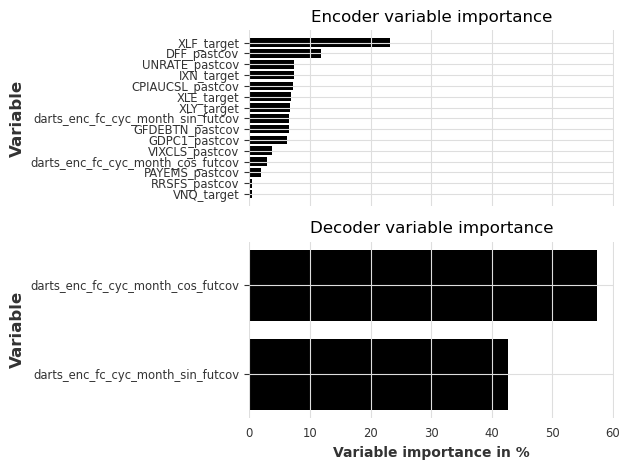

,0
VNQ_target,0.5
RRSFS_pastcov,0.5
PAYEMS_pastcov,1.9
darts_enc_fc_cyc_month_cos_futcov,2.9
VIXCLS_pastcov,3.8
GDPC1_pastcov,6.3
GFDEBTN_pastcov,6.5
darts_enc_fc_cyc_month_sin_futcov,6.6
XLY_target,6.7
XLE_target,6.9


,0
darts_enc_fc_cyc_month_sin_futcov,42.7
darts_enc_fc_cyc_month_cos_futcov,57.3


In [49]:
from darts.explainability import TFTExplainer

explainer = TFTExplainer(tftmodel)

explainability_result = explainer.explain()
explainer.plot_variable_selection(explainability_result)
display(explainability_result.get_encoder_importance().T)
display(explainability_result.get_decoder_importance().T)

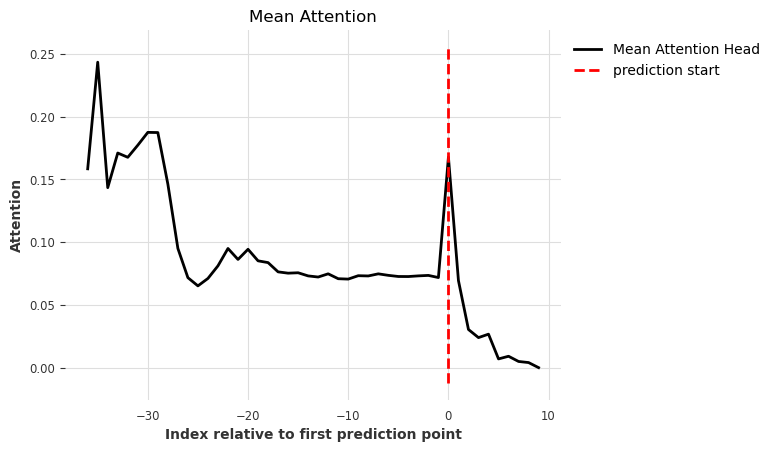

<Axes: title={'center': 'Mean Attention'}, xlabel='Index relative to first prediction point', ylabel='Attention'>

In [50]:
explainer.plot_attention(explainability_result, plot_type="time")

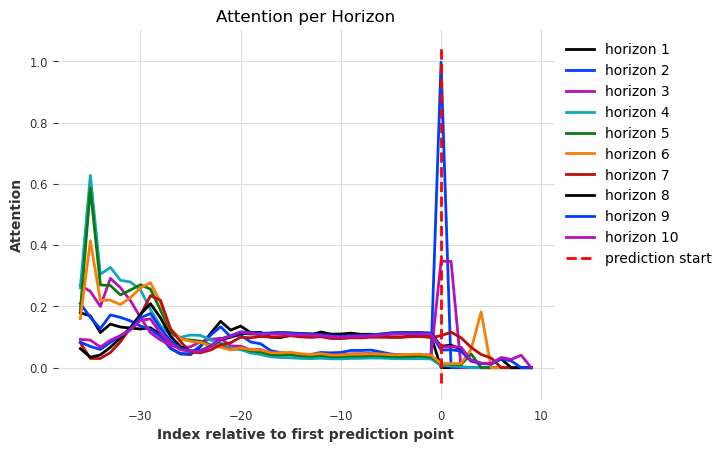

<Axes: title={'center': 'Attention per Horizon'}, xlabel='Index relative to first prediction point', ylabel='Attention'>

In [51]:
explainer.plot_attention(explainability_result, plot_type="all")

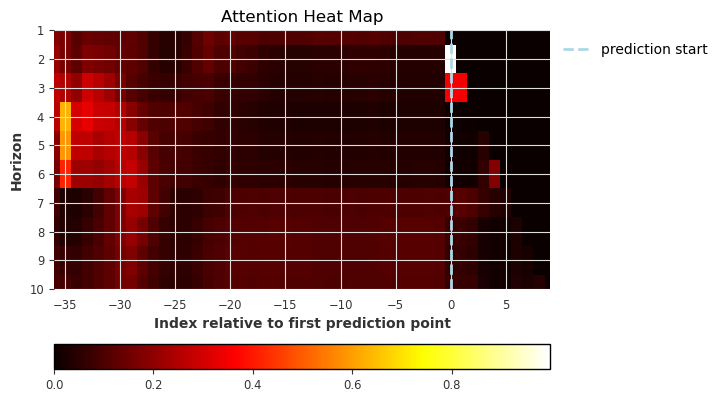

<Axes: title={'center': 'Attention Heat Map'}, xlabel='Index relative to first prediction point', ylabel='Horizon'>

In [52]:
explainer.plot_attention(explainability_result, plot_type="heatmap")

# KIV: Backtesting: simulate historical forecasting

Fit model on historically 

https://unit8co.github.io/darts/quickstart/00-quickstart.html#Machine-learning-and-global-models

https://unit8co.github.io/darts/examples/13-TFT-examples.html#id2

In [46]:
last_points_only = False
backtest_series = tftmodel.historical_forecasts(
    series_transformed,
    num_samples=num_samples,
    start=date_to_split_before,
    forecast_horizon=120, 
    stride=1 if last_points_only else 120,
    retrain=False,
    last_points_only=last_points_only,
    overlap_end=True,
    verbose=True,
)


ValueError: Cannot build a single input for prediction with the provided model, `series` and `*_covariates` at series index: 0. The minimum prediction input time index requirements were not met. Please check the time index of `series` and `*_covariates`.

In [ ]:
pd.Timestamp('2014-02-01 00:00:00')

In [ ]:
covariates_transformed

In [ ]:
covariates_train.pd_dataframe()

In [ ]:
backtest_series = tftmodel.historical_forecasts(
    ytrain_transformed,
    past_covariates = covariates_train_transformed,
    start = pd.Timestamp('2014-01-01'),
    retrain = False
)

In [ ]:
backtest_series

## Look at predictions on the validation set

perform a one-shot prediction of 12 observations using the “current” mode


Normalize "series" Y by MinMaxScaler
transformer = Scaler()  ## Scaling on Y (Forecasted Variable) only
ytrain_transformed = transformer.fit_transform(ytrain)
yval_transformed = transformer.transform(yval)
series_transformed = transformer.transform(series)


### Split X
scaler_covs = Scaler()
covariates_train, covariates_val = covariates.split_before(date_to_split_before)
scaler_covs.fit(covariates_train)
covariates_transformed = scaler_covs.transform(covariates)


In [ ]:
historical_forecasts

In [ ]:
historical_forecasts = tftmodel.historical_forecasts(ytrain_transformed,
                                                     covariates_train_transformed,
                                                     retrain = False)
## In Sample 
print("MAPE: {:.2f}%".format(mape(historical_forecasts, ytrain_transformed.slice(pd.Timestamp("2017-01-02"), pd.Timestamp("2023-12-01")))))
print("RMSE: {:.2f}%".format(rmse(historical_forecasts, ytrain_transformed.slice(pd.Timestamp("2017-01-02"), pd.Timestamp("2023-12-01")))))

Predicting: |          | 0/? [00:00<?, ?it/s]

MAPE: 21.80%
RMSE: 0.24%


None

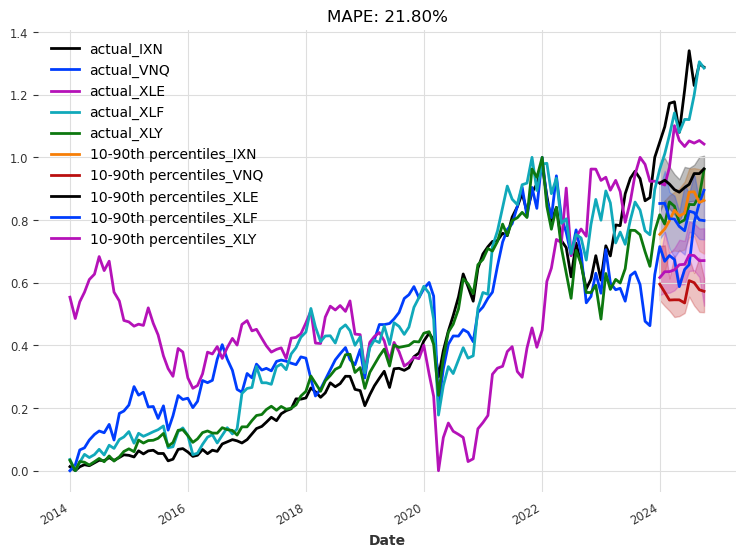

In [71]:
def eval_model(model, n, actual_series, val_series):
    pred_series = model.predict(n=n, num_samples=120)

    # plot actual series
    plt.figure(figsize=figsize)
    actual_series[: pred_series.end_time()].plot(label="actual")

    # plot prediction with quantile ranges
    # pred_series.plot(
    #     low_quantile=lowest_q, high_quantile=highest_q, label=label_q_outer
    # )
    pred_series.plot(low_quantile=low_q, high_quantile=high_q, label=label_q_inner)

    plt.title("MAPE: {:.2f}%".format(mape(val_series, pred_series)))
    plt.legend()
    
    print("MAPE: {:.2f}%".format(mape(val_series, pred_series)))
    print("RMSE: {:.2f}%".format(rmse(val_series, pred_series)))


## Out of Sample Performance
display(eval_model(tftmodel, len(yval_transformed), series_transformed, yval_transformed)
)

Predicting: |          | 0/? [00:00<?, ?it/s]

MAPE: 15.39%
RMSE: 15.13%


None

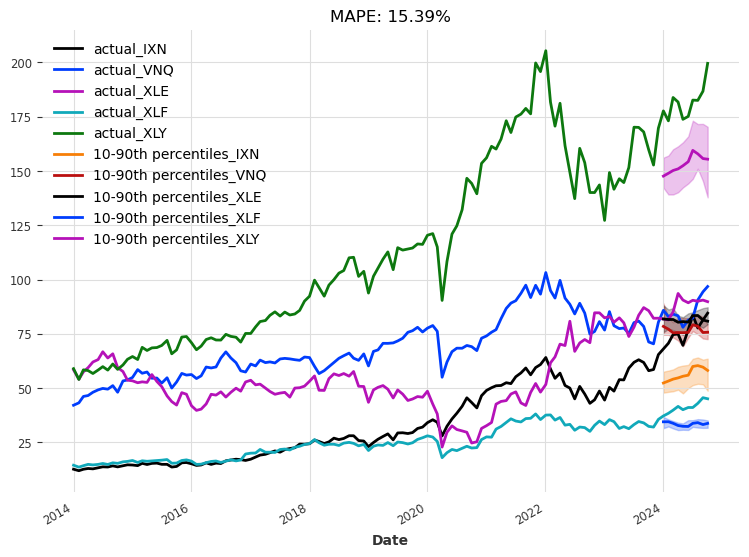

In [70]:
def eval_model2(model, n, actual_series, val_series):
    pred_series = model.predict(n=n, num_samples=120)
    pred_series = transformer.inverse_transform(pred_series)

    # plot actual series
    plt.figure(figsize=figsize)
    actual_series[: pred_series.end_time()].plot(label="actual")

    # plot prediction with quantile ranges
    # pred_series.plot(
    #     low_quantile=lowest_q, high_quantile=highest_q, label=label_q_outer
    # )
    pred_series.plot(low_quantile=low_q, high_quantile=high_q, label=label_q_inner)

    plt.title("MAPE: {:.2f}%".format(mape(val_series, pred_series)))
    plt.legend()
    
    print("MAPE: {:.2f}%".format(mape(val_series, pred_series)))
    print("RMSE: {:.2f}%".format(rmse(val_series, pred_series)))
display(eval_model2(tftmodel, len(yval), series, yval))

https://unit8co.github.io/darts/generated_api/darts.models.forecasting.tft_model.html 

Look at this for model attributes & methods

methods: residuals() ; predict() ; gridsearch() ; backtest ; historical_forecasts

